In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot

In [2]:
##### function definitions
# different definitions of hadronic energy
def cal_Ehadtrue(pdg, E, m):
    Ehadtrue = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 2112]:
            Ehadtrue += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadtrue += E[ip]
    return Ehadtrue
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def get_Ehad_array(vars_dict, cal_Ehad_func):
    nevts = len(vars_dict["Ev"])
    pdgi = vars_dict["pdgi"]
    Ei = vars_dict["Ei"]
    mi = []
    Eavail_i = []
    pdgf = vars_dict["pdgf"]
    Ef = vars_dict["Ef"]
    mf = []
    Eavail_f = []
    
    for ievt in range(nevts):
        pisq = vars_dict["pxi"][ievt]*vars_dict["pxi"][ievt] + vars_dict["pyi"][ievt]*vars_dict["pyi"][ievt] + vars_dict["pzi"][ievt]*vars_dict["pzi"][ievt]
        mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
        Eavail_i.append(cal_Ehad_func(pdgi[ievt], Ei[ievt], mi[ievt]))
        
        mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
        Eavail_f.append(cal_Ehad_func(pdgf[ievt], Ef[ievt], mf[ievt]))
        
    return np.array(Eavail_i), np.array(Eavail_f)

# neutrino energy bias
def get_Ebias(vars_dict, cal_Ehad_func):
    Ehadi, Ehadf = get_Ehad_array(vars_dict, cal_Ehad_func)
    return vars_dict["El"] + Ehadi - vars_dict["Ev"], vars_dict["El"] + Ehadf - vars_dict["Ev"]
def get_relative_Ebias(vars_dict, cal_Ehad_func):
    Ebiasi, Ebiasf = get_Ebias(vars_dict, cal_Ehad_func)
    return Ebiasi / vars_dict["Ev"], Ebiasf / vars_dict["Ev"]

# other useful
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

def fill_between_gradient(ax, x, y, y_upp, y_low,
                          alpha=0.3, resolution=1000, zorder=0,
                          cmap=None, label=None):
    """
    Draw a vertical red-white-blue gradient between y_upp and y_low on the given axes.
    White is centered at y(x), red at y_upp, and blue at y_low.

    Parameters:
    - ax: matplotlib Axes object
    - x: 1D array of x-coordinates
    - y: 1D array for the white center line
    - y_upp: 1D array for the red-side boundary
    - y_low: 1D array for the blue-side boundary
    - alpha: float (0 to 1), maximum opacity of the fill
    - resolution: int, resolution for the rendered gradient image
    - zorder: drawing layer
    - cmap: optional colormap (default is red-white-blue)
    - label: optional label (not used in legend but allows consistent API)
    """
    import numpy as np
    from scipy.interpolate import interp1d
    from matplotlib.colors import LinearSegmentedColormap

    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("rwb", ["blue", "white", "red"])

    # Ensure input as arrays
    x = np.asarray(x)
    y = np.asarray(y)
    y_upp = np.asarray(y_upp)
    y_low = np.asarray(y_low)

    dy = (y_upp - y_low) / 2

    # Create meshgrid for plotting
    nx, ny = resolution, resolution
    X = np.linspace(x.min(), x.max(), nx)
    Y = np.linspace(min(y_upp.min(), y_low.min()) - 0.2,
                    max(y_upp.max(), y_low.max()) + 0.2, ny)
    XX, YY = np.meshgrid(X, Y)

    # Interpolate center and width to the mesh x values
    center_func = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
    dy_func = interp1d(x, dy, bounds_error=False, fill_value="extrapolate")
    y0 = center_func(X)
    dy_vals = dy_func(X)

    # Interpolate upper/lower bounds *before* evaluating the mask
    y_upp_interp = interp1d(x, y_upp, bounds_error=False, fill_value="extrapolate")(X)
    y_low_interp = interp1d(x, y_low, bounds_error=False, fill_value="extrapolate")(X)
    y_top = np.maximum(y_upp_interp, y_low_interp)
    y_bot = np.minimum(y_upp_interp, y_low_interp)

    # Safe division to normalize gradient [-1, 1]
    def safe_divide(numerator, denominator, default_value=100):
        numerator, denominator = np.broadcast_arrays(numerator, denominator)
        result = np.ones_like(numerator)
        mask_both_zero = (numerator == 0) & (denominator == 0)
        mask_only_zero = (denominator == 0) & ~mask_both_zero
        mask_valid = ~mask_both_zero & ~mask_only_zero
        result[mask_valid] = numerator[mask_valid] / denominator[mask_valid]
        result[mask_only_zero] = default_value
        return np.nan_to_num(result, nan=default_value)

    norm_val = safe_divide(YY - y0, dy_vals)
    norm_val = np.clip(norm_val, -1, 1)

    # Alpha mask: only show pixels between the two bounds
    alpha_mask = ((YY >= y_bot) & (YY <= y_top)).astype(float) * alpha

    # Draw the image
    ax.imshow(norm_val,
              extent=[X.min(), X.max(), Y.min(), Y.max()],
              origin='lower',
              aspect='auto',
              cmap=cmap,
              alpha=alpha_mask,
              zorder=zorder,
              label=label)


### nuebar appearance

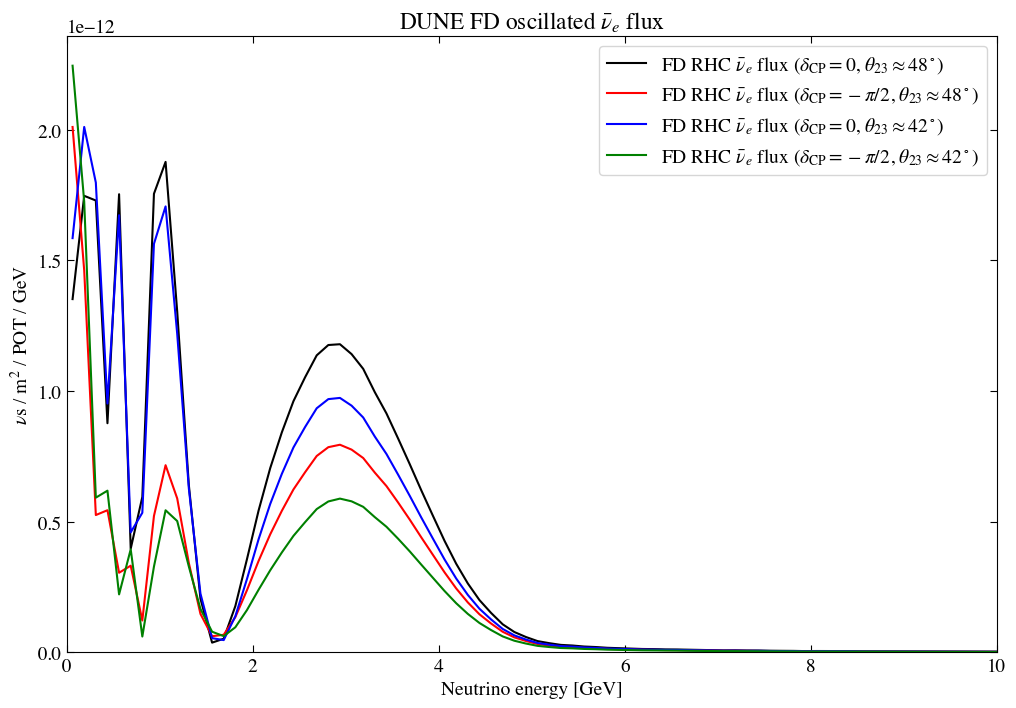

In [3]:
# nuebar appearance
FDosc_Ev = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,1.1875,1.3125,1.4375,1.5625,1.6875,1.8125,1.9375,2.0625,2.1875,2.3125,2.4375,2.5625,2.6875,2.8125,2.9375,3.0625,3.1875,3.3125,3.4375,3.5625,3.6875,3.8125,3.9375,4.0625,4.1875,4.3125,4.4375,4.5625,4.6875,4.8125,4.9375,5.0625,5.1875,5.3125,5.4375,5.5625,5.6875,5.8125,5.9375,6.0625,6.1875,6.3125,6.4375,6.5625,6.6875,6.8125,6.9375,7.0625,7.1875,7.3125,7.4375,7.5625,7.6875,7.8125,7.9375,8.0625,8.1875,8.3125,8.4375,8.5625,8.6875,8.8125,8.9375,9.0625,9.1875,9.3125,9.4375,9.5625,9.6875,9.8125,9.9375,10.0625,10.1875,10.3125,10.4375,10.5625,10.6875,10.8125,10.9375,11.0625,11.1875,11.3125,11.4375,11.5625,11.6875,11.8125,11.9375,12.0625,12.1875,12.3125,12.4375,12.5625,12.6875,12.8125,12.9375,13.0625,13.1875,13.3125,13.4375,13.5625,13.6875,13.8125,13.9375,14.0625,14.1875,14.3125,14.4375,14.5625,14.6875,14.8125,14.9375,15.0625,15.1875,15.3125,15.4375,15.5625,15.6875,15.8125,15.9375,16.0625,16.1875,16.3125,16.4375,16.5625,16.6875,16.8125,16.9375,17.0625,17.1875,17.3125,17.4375,17.5625,17.6875,17.8125,17.9375,18.0625,18.1875,18.3125,18.4375,18.5625,18.6875,18.8125,18.9375,19.0625,19.1875,19.3125,19.4375,19.5625,19.6875,19.8125,19.9375,20.0625,20.1875,20.3125,20.4375,20.5625,20.6875,20.8125,20.9375,21.0625,21.1875,21.3125,21.4375,21.5625,21.6875,21.8125,21.9375,22.0625,22.1875,22.3125,22.4375,22.5625,22.6875,22.8125,22.9375,23.0625,23.1875,23.3125,23.4375,23.5625,23.6875,23.8125,23.9375,24.0625,24.1875,24.3125,24.4375,24.5625,24.6875,24.8125,24.9375,25.0625,25.1875,25.3125,25.4375,25.5625,25.6875,25.8125,25.9375,26.0625,26.1875,26.3125,26.4375,26.5625,26.6875,26.8125,26.9375,27.0625,27.1875,27.3125,27.4375,27.5625,27.6875,27.8125,27.9375,28.0625,28.1875,28.3125,28.4375,28.5625,28.6875,28.8125,28.9375,29.0625,29.1875,29.3125,29.4375,29.5625,29.6875,29.8125,29.9375,30.0625,30.1875,30.3125,30.4375,30.5625,30.6875,30.8125,30.9375,31.0625,31.1875,31.3125,31.4375,31.5625,31.6875,31.8125,31.9375,32.0625,32.1875,32.3125,32.4375,32.5625,32.6875,32.8125,32.9375,33.0625,33.1875,33.3125,33.4375,33.5625,33.6875,33.8125,33.9375,34.0625,34.1875,34.3125,34.4375,34.5625,34.6875,34.8125,34.9375,35.0625,35.1875,35.3125,35.4375,35.5625,35.6875,35.8125,35.9375,36.0625,36.1875,36.3125,36.4375,36.5625,36.6875,36.8125,36.9375,37.0625,37.1875,37.3125,37.4375,37.5625,37.6875,37.8125,37.9375,38.0625,38.1875,38.3125,38.4375,38.5625,38.6875,38.8125,38.9375,39.0625,39.1875,39.3125,39.4375,39.5625,39.6875,39.8125,39.9375,40.0625,40.1875,40.3125,40.4375,40.5625,40.6875,40.8125,40.9375,41.0625,41.1875,41.3125,41.4375,41.5625,41.6875,41.8125,41.9375,42.0625,42.1875,42.3125,42.4375,42.5625,42.6875,42.8125,42.9375,43.0625,43.1875,43.3125,43.4375,43.5625,43.6875,43.8125,43.9375,44.0625,44.1875,44.3125,44.4375,44.5625,44.6875,44.8125,44.9375,45.0625,45.1875,45.3125,45.4375,45.5625,45.6875,45.8125,45.9375,46.0625,46.1875,46.3125,46.4375,46.5625,46.6875,46.8125,46.9375,47.0625,47.1875,47.3125,47.4375,47.5625,47.6875,47.8125,47.9375,48.0625,48.1875,48.3125,48.4375,48.5625,48.6875,48.8125,48.9375,49.0625,49.1875,49.3125,49.4375,49.5625,49.6875,49.8125,49.9375,50.0625,50.1875,50.3125,50.4375,50.5625,50.6875,50.8125,50.9375,51.0625,51.1875,51.3125,51.4375,51.5625,51.6875,51.8125,51.9375,52.0625,52.1875,52.3125,52.4375,52.5625,52.6875,52.8125,52.9375,53.0625,53.1875,53.3125,53.4375,53.5625,53.6875,53.8125,53.9375,54.0625,54.1875,54.3125,54.4375,54.5625,54.6875,54.8125,54.9375,55.0625,55.1875,55.3125,55.4375,55.5625,55.6875,55.8125,55.9375,56.0625,56.1875,56.3125,56.4375,56.5625,56.6875,56.8125,56.9375,57.0625,57.1875,57.3125,57.4375,57.5625,57.6875,57.8125,57.9375,58.0625,58.1875,58.3125,58.4375,58.5625,58.6875,58.8125,58.9375,59.0625,59.1875,59.3125,59.4375,59.5625,59.6875,59.8125,59.9375,60.0625,60.1875,60.3125,60.4375,60.5625,60.6875,60.8125,60.9375,61.0625,61.1875,61.3125,61.4375,61.5625,61.6875,61.8125,61.9375,62.0625,62.1875,62.3125,62.4375,62.5625,62.6875,62.8125,62.9375,63.0625,63.1875,63.3125,63.4375,63.5625,63.6875,63.8125,63.9375,64.0625,64.1875,64.3125,64.4375,64.5625,64.6875,64.8125,64.9375,65.0625,65.1875,65.3125,65.4375,65.5625,65.6875,65.8125,65.9375,66.0625,66.1875,66.3125,66.4375,66.5625,66.6875,66.8125,66.9375,67.0625,67.1875,67.3125,67.4375,67.5625,67.6875,67.8125,67.9375,68.0625,68.1875,68.3125,68.4375,68.5625,68.6875,68.8125,68.9375,69.0625,69.1875,69.3125,69.4375,69.5625,69.6875,69.8125,69.9375])
ND_Flux_RHCnuebar = np.array([4.99407e-07,1.11771e-06,1.56678e-06,1.89464e-06,2.15844e-06,2.54748e-06,2.50785e-06,2.46185e-06,2.38357e-06,2.34656e-06,2.31455e-06,2.17288e-06,2.1125e-06,1.96456e-06,1.75908e-06,1.78477e-06,1.71524e-06,1.69034e-06,1.67668e-06,1.50688e-06,1.31306e-06,1.33402e-06,1.25025e-06,1.40336e-06,1.09677e-06,1.07918e-06,1.09605e-06,9.08023e-07,8.33947e-07,8.96579e-07,1.08413e-06,7.95951e-07,7.69254e-07,6.2454e-07,7.10537e-07,6.95873e-07,6.3988e-07,6.87295e-07,4.64558e-07,4.98749e-07,5.57184e-07,4.45068e-07,5.11081e-07,3.25566e-07,4.74803e-07,3.54334e-07,3.11478e-07,3.34797e-07,4.12516e-07,3.36378e-07,2.91624e-07,3.08101e-07,3.38049e-07,3.06611e-07,2.49372e-07,2.62829e-07,2.74455e-07,2.30295e-07,2.15621e-07,2.15121e-07,2.22106e-07,2.12332e-07,1.96408e-07,1.97735e-07,1.9323e-07,1.9323e-07,1.9323e-07,1.9323e-07,1.96717e-07,1.96717e-07,1.96717e-07,1.96717e-07,1.50688e-07,1.50688e-07,1.50688e-07,1.50688e-07,1.31193e-07,1.31193e-07,1.31193e-07,1.31193e-07,1.15247e-07,1.15247e-07,1.15247e-07,1.15247e-07,1.09085e-07,1.09085e-07,1.09085e-07,1.09085e-07,9.25598e-08,9.25598e-08,9.25598e-08,9.25598e-08,8.13413e-08,8.13413e-08,8.13413e-08,8.13413e-08,7.24818e-08,7.24818e-08,7.24818e-08,7.24818e-08,7.48841e-08,7.48841e-08,7.48841e-08,7.48841e-08,5.23057e-08,5.23057e-08,5.23057e-08,5.23057e-08,6.90174e-08,6.90174e-08,6.90174e-08,6.90174e-08,4.52699e-08,4.52699e-08,4.52699e-08,4.52699e-08,4.52281e-08,4.52281e-08,4.52281e-08,4.52281e-08,4.47056e-08,4.47056e-08,4.47056e-08,4.47056e-08,3.2089e-08,3.2089e-08,3.2089e-08,3.2089e-08,2.49664e-08,2.49664e-08,2.49664e-08,2.49664e-08,2.45684e-08,2.45684e-08,2.45684e-08,2.45684e-08,2.84731e-08,2.84731e-08,2.84731e-08,2.84731e-08,2.08186e-08,2.08186e-08,2.08186e-08,2.08186e-08,1.9826e-08,1.9826e-08,1.9826e-08,1.9826e-08,2.30386e-08,2.30386e-08,2.30386e-08,2.30386e-08,1.72759e-08,1.72759e-08,1.72759e-08,1.72759e-08,1.70976e-08,1.70976e-08,1.70976e-08,1.70976e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.42853e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,1.02721e-08,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,7.202e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,4.50493e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12101e-09,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.12881e-08,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.04618e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,2.43767e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,1.26261e-09,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,2.24967e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,5.0714e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,4.40719e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,6.43725e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == 0, theta_23 ≈ 48.3
FDosc_Flux_RHCnuebar_1300 = np.array([1.35213e-12,1.74745e-12,1.72951e-12,8.77047e-13,1.75358e-12,3.96579e-13,5.94834e-13,1.75536e-12,1.87737e-12,1.30454e-12,6.40824e-13,2.05626e-13,3.7254e-14,5.22173e-14,1.76968e-13,3.56464e-13,5.42764e-13,7.05061e-13,8.42006e-13,9.61504e-13,1.0529e-12,1.13683e-12,1.1764e-12,1.17943e-12,1.14158e-12,1.08521e-12,9.95781e-13,9.14582e-13,8.18814e-13,7.20716e-13,6.19836e-13,5.22544e-13,4.26573e-13,3.39146e-13,2.63713e-13,2.00162e-13,1.50971e-13,1.07357e-13,7.78909e-14,5.87256e-14,4.30921e-14,3.52335e-14,2.86352e-14,2.62506e-14,2.23409e-14,2.04079e-14,1.75198e-14,1.58991e-14,1.4485e-14,1.29601e-14,1.24281e-14,1.12712e-14,1.09871e-14,1.01029e-14,9.49616e-15,8.54606e-15,7.65053e-15,7.85618e-15,7.21831e-15,7.10955e-15,6.25611e-15,6.09804e-15,5.66028e-15,4.83641e-15,5.19719e-15,5.06593e-15,4.93926e-15,4.81699e-15,4.03399e-15,3.93611e-15,3.84155e-15,3.75019e-15,3.32687e-15,3.24931e-15,3.1743e-15,3.10175e-15,2.93174e-15,2.86604e-15,2.80243e-15,2.74083e-15,2.37222e-15,2.32108e-15,2.27152e-15,2.22347e-15,2.0299e-15,1.98777e-15,1.94689e-15,1.90723e-15,1.74185e-15,1.70701e-15,1.67318e-15,1.64032e-15,1.63153e-15,1.60005e-15,1.56946e-15,1.53971e-15,1.26021e-15,1.23674e-15,1.21391e-15,1.19169e-15,1.16105e-15,1.14016e-15,1.11981e-15,1.09999e-15,9.39561e-16,9.23206e-16,9.07266e-16,8.91728e-16,8.3816e-16,8.24035e-16,8.10259e-16,7.96819e-16,7.52658e-16,7.40368e-16,7.28373e-16,7.16662e-16,6.67384e-16,6.56816e-16,6.46494e-16,6.3641e-16,5.57028e-16,5.48467e-16,5.401e-16,5.31921e-16,4.6619e-16,4.59231e-16,4.52426e-16,4.45768e-16,3.89615e-16,3.83962e-16,3.7843e-16,3.73015e-16,3.15876e-16,3.11418e-16,3.07053e-16,3.02778e-16,2.63173e-16,2.59558e-16,2.56016e-16,2.52546e-16,2.37618e-16,2.34438e-16,2.31322e-16,2.28267e-16,2.00914e-16,1.98294e-16,1.95725e-16,1.93204e-16,1.48109e-16,1.46225e-16,1.44377e-16,1.42564e-16,1.3993e-16,1.38193e-16,1.36489e-16,1.34816e-16,1.17483e-16,1.1606e-16,1.14662e-16,1.13289e-16,9.07897e-17,8.97153e-17,8.86598e-17,8.76226e-17,8.66034e-17,8.56018e-17,8.46174e-17,8.36497e-17,8.26984e-17,8.17632e-17,8.08436e-17,7.99394e-17,7.90502e-17,7.81757e-17,7.73155e-17,7.64693e-17,6.20517e-17,6.13798e-17,6.07187e-17,6.00682e-17,5.9428e-17,5.8798e-17,5.81779e-17,5.75674e-17,5.69665e-17,5.63749e-17,5.57925e-17,5.52189e-17,5.46542e-17,5.4098e-17,5.35502e-17,5.30106e-17,3.97016e-17,3.93056e-17,3.89154e-17,3.85309e-17,3.81521e-17,3.77788e-17,3.7411e-17,3.70484e-17,3.66911e-17,3.6339e-17,3.59918e-17,3.56496e-17,3.53122e-17,3.49796e-17,3.46516e-17,3.43282e-17,2.52231e-17,2.49899e-17,2.47598e-17,2.4533e-17,2.43091e-17,2.40884e-17,2.38706e-17,2.36558e-17,2.34438e-17,2.32346e-17,2.30283e-17,2.28246e-17,2.26236e-17,2.24253e-17,2.22296e-17,2.20364e-17,1.8352e-17,1.81939e-17,1.80377e-17,1.78836e-17,1.77315e-17,1.75812e-17,1.74329e-17,1.72864e-17,1.71418e-17,1.6999e-17,1.68579e-17,1.67186e-17,1.6581e-17,1.64451e-17,1.63108e-17,1.61782e-17,1.10589e-17,1.09697e-17,1.08816e-17,1.07945e-17,1.07085e-17,1.06235e-17,1.05395e-17,1.04565e-17,1.03744e-17,1.02933e-17,1.02132e-17,1.0134e-17,1.00557e-17,9.97829e-18,9.90179e-18,9.82616e-18,7.365e-18,7.30917e-18,7.25397e-18,7.19939e-18,7.14542e-18,7.09206e-18,7.03929e-18,6.98711e-18,6.9355e-18,6.88446e-18,6.83398e-18,6.78405e-18,6.73467e-18,6.68582e-18,6.63751e-18,6.58971e-18,4.06929e-18,4.04019e-18,4.01141e-18,3.98293e-18,3.95475e-18,3.92687e-18,3.89928e-18,3.87198e-18,3.84497e-18,3.81824e-18,3.79178e-18,3.7656e-18,3.73969e-18,3.71405e-18,3.68866e-18,3.66354e-18,2.79453e-18,2.77562e-18,2.75691e-18,2.73838e-18,2.72004e-18,2.70188e-18,2.68391e-18,2.66611e-18,2.64849e-18,2.63104e-18,2.61376e-18,2.59665e-18,2.57971e-18,2.56294e-18,2.54632e-18,2.52987e-18,2.01573e-18,2.00279e-18,1.98998e-18,1.97728e-18,1.96471e-18,1.95226e-18,1.93992e-18,1.9277e-18,1.9156e-18,1.9036e-18,1.89172e-18,1.87996e-18,1.8683e-18,1.85674e-18,1.8453e-18,1.83396e-18,1.51132e-18,1.50209e-18,1.49295e-18,1.48388e-18,1.4749e-18,1.466e-18,1.45718e-18,1.44844e-18,1.43978e-18,1.43119e-18,1.42269e-18,1.41425e-18,1.40589e-18,1.39761e-18,1.3894e-18,1.38126e-18,1.66251e-18,1.65283e-18,1.64323e-18,1.63371e-18,1.62428e-18,1.61493e-18,1.60565e-18,1.59646e-18,1.58735e-18,1.57831e-18,1.56936e-18,1.56047e-18,1.55166e-18,1.54293e-18,1.53427e-18,1.52568e-18,5.93732e-19,5.90428e-19,5.8715e-19,5.839e-19,5.80677e-19,5.77481e-19,5.7431e-19,5.71166e-19,5.68047e-19,5.64954e-19,5.61886e-19,5.58843e-19,5.55825e-19,5.52831e-19,5.49861e-19,5.46915e-19,4.33854e-19,4.31542e-19,4.29248e-19,4.26973e-19,4.24715e-19,4.22475e-19,4.20253e-19,4.18049e-19,4.15861e-19,4.13691e-19,4.11538e-19,4.09401e-19,4.07281e-19,4.05178e-19,4.0309e-19,4.01019e-19,1.38887e-19,1.38177e-19,1.37472e-19,1.36773e-19,1.36079e-19,1.3539e-19,1.34707e-19,1.34029e-19,1.33355e-19,1.32687e-19,1.32024e-19,1.31366e-19,1.30713e-19,1.30064e-19,1.29421e-19,1.28782e-19,1.42801e-19,1.421e-19,1.41404e-19,1.40712e-19,1.40026e-19,1.39345e-19,1.38669e-19,1.37998e-19,1.37331e-19,1.3667e-19,1.36013e-19,1.35361e-19,1.34713e-19,1.3407e-19,1.33432e-19,1.32799e-19,1.89626e-19,1.8873e-19,1.8784e-19,1.86956e-19,1.86079e-19,1.85207e-19,1.84342e-19,1.83483e-19,1.8263e-19,1.81782e-19,1.80941e-19,1.80105e-19,1.79276e-19,1.78451e-19,1.77633e-19,1.7682e-19,6.31181e-20,6.28306e-20,6.25451e-20,6.22615e-20,6.19798e-20,6.17e-20,6.14221e-20,6.11461e-20,6.08719e-20,6.05996e-20,6.03291e-20,6.00604e-20,5.97935e-20,5.95284e-20,5.9265e-20,5.90034e-20,9.20188e-20,9.16144e-20,9.12126e-20,9.08134e-20,9.04169e-20,9.00229e-20,8.96316e-20,8.92427e-20,8.88564e-20,8.84726e-20,8.80913e-20,8.77124e-20,8.7336e-20,8.6962e-20,8.65903e-20,8.62211e-20,3.19501e-20,3.18144e-20,3.16796e-20,3.15457e-20,3.14126e-20,3.12803e-20,3.11489e-20,3.10183e-20,3.08885e-20,3.07595e-20,3.06313e-20,3.0504e-20,3.03774e-20,3.02516e-20,3.01266e-20,3.00023e-20,3.1391e-20,3.1262e-20,3.11339e-20,3.10066e-20,3.088e-20,3.07542e-20,3.06292e-20,3.05049e-20,3.03814e-20,3.02586e-20,3.01366e-20,3.00153e-20,2.98948e-20,2.9775e-20,2.96558e-20,2.95374e-20,1.55422e-20,1.54804e-20,1.54189e-20,1.53579e-20,1.52972e-20,1.52368e-20,1.51768e-20,1.51172e-20,1.50579e-20,1.49989e-20,1.49403e-20,1.48821e-20,1.48242e-20,1.47666e-20,1.47093e-20,1.46524e-20,1.58495e-20,1.57884e-20,1.57277e-20,1.56673e-20,1.56073e-20,1.55476e-20,1.54882e-20,1.54292e-20,1.53705e-20,1.53122e-20,1.52542e-20,1.51965e-20,1.51391e-20,1.50821e-20,1.50254e-20,1.4969e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300p = np.array([1.22703e-12,1.70179e-12,1.78152e-12,8.63266e-13,1.87953e-12,3.87374e-13,7.05596e-13,1.89044e-12,1.95163e-12,1.32303e-12,6.34789e-13,1.99975e-13,4.32722e-14,7.31663e-14,2.12187e-13,4.03268e-13,5.97027e-13,7.62796e-13,9.00932e-13,1.0206e-12,1.11082e-12,1.19358e-12,1.23025e-12,1.22935e-12,1.18655e-12,1.12522e-12,1.03029e-12,9.44496e-13,8.44178e-13,7.41922e-13,6.37205e-13,5.36521e-13,4.37487e-13,3.47462e-13,2.6992e-13,2.04692e-13,1.5426e-13,1.09613e-13,7.94704e-14,5.98763e-14,4.3909e-14,3.58802e-14,2.91445e-14,2.67035e-14,2.27151e-14,2.07399e-14,1.77969e-14,1.61437e-14,1.47019e-14,1.31492e-14,1.26048e-14,1.14274e-14,1.11357e-14,1.02362e-14,9.61853e-15,8.65365e-15,7.74466e-15,7.95068e-15,7.30324e-15,7.1914e-15,6.32661e-15,6.16532e-15,5.72145e-15,4.88762e-15,5.25112e-15,5.11747e-15,4.98854e-15,4.86413e-15,4.07272e-15,3.9732e-15,3.87709e-15,3.78425e-15,3.35654e-15,3.27778e-15,3.20163e-15,3.12799e-15,2.95612e-15,2.88947e-15,2.82496e-15,2.76251e-15,2.39067e-15,2.33884e-15,2.28862e-15,2.23995e-15,2.04471e-15,2.00204e-15,1.96066e-15,1.92051e-15,1.7538e-15,1.71854e-15,1.68432e-15,1.65107e-15,1.64207e-15,1.61024e-15,1.57931e-15,1.54924e-15,1.2679e-15,1.24418e-15,1.22111e-15,1.19866e-15,1.16775e-15,1.14665e-15,1.1261e-15,1.10608e-15,9.44698e-16,9.28187e-16,9.12097e-16,8.96415e-16,8.42508e-16,8.28255e-16,8.14355e-16,8.00797e-16,7.56368e-16,7.43972e-16,7.31873e-16,7.20064e-16,6.70513e-16,6.59858e-16,6.49451e-16,6.39286e-16,5.59515e-16,5.50887e-16,5.42455e-16,5.34212e-16,4.68174e-16,4.61163e-16,4.54307e-16,4.476e-16,3.91197e-16,3.85503e-16,3.79932e-16,3.74479e-16,3.17101e-16,3.12613e-16,3.08217e-16,3.03914e-16,2.64149e-16,2.6051e-16,2.56944e-16,2.53451e-16,2.3846e-16,2.35261e-16,2.32124e-16,2.2905e-16,2.01596e-16,1.9896e-16,1.96375e-16,1.93839e-16,1.4859e-16,1.46695e-16,1.44837e-16,1.43012e-16,1.40366e-16,1.38619e-16,1.36905e-16,1.35222e-16,1.17834e-16,1.16403e-16,1.14997e-16,1.13617e-16,9.10499e-17,8.99697e-17,8.89086e-17,8.7866e-17,8.68415e-17,8.58348e-17,8.48453e-17,8.38727e-17,8.29167e-17,8.19768e-17,8.10527e-17,8.01441e-17,7.92506e-17,7.83718e-17,7.75075e-17,7.66574e-17,6.22027e-17,6.15277e-17,6.08636e-17,6.02101e-17,5.9567e-17,5.89342e-17,5.83113e-17,5.76982e-17,5.70946e-17,5.65004e-17,5.59154e-17,5.53395e-17,5.47723e-17,5.42137e-17,5.36636e-17,5.31219e-17,3.97841e-17,3.93864e-17,3.89946e-17,3.86086e-17,3.82283e-17,3.78536e-17,3.74843e-17,3.71203e-17,3.67616e-17,3.64081e-17,3.60596e-17,3.57161e-17,3.53775e-17,3.50436e-17,3.47144e-17,3.43898e-17,2.5268e-17,2.50339e-17,2.4803e-17,2.45753e-17,2.43507e-17,2.41292e-17,2.39106e-17,2.3695e-17,2.34823e-17,2.32724e-17,2.30654e-17,2.2861e-17,2.26594e-17,2.24604e-17,2.2264e-17,2.20702e-17,1.83799e-17,1.82212e-17,1.80646e-17,1.791e-17,1.77574e-17,1.76067e-17,1.74579e-17,1.7311e-17,1.71659e-17,1.70226e-17,1.68811e-17,1.67414e-17,1.66034e-17,1.64671e-17,1.63324e-17,1.61994e-17,1.10733e-17,1.09838e-17,1.08955e-17,1.08081e-17,1.07219e-17,1.06366e-17,1.05524e-17,1.04691e-17,1.03868e-17,1.03055e-17,1.02252e-17,1.01458e-17,1.00673e-17,9.98966e-18,9.91295e-18,9.83712e-18,7.37314e-18,7.31716e-18,7.26182e-18,7.2071e-18,7.153e-18,7.0995e-18,7.0466e-18,6.99428e-18,6.94255e-18,6.89139e-18,6.84078e-18,6.79074e-18,6.74124e-18,6.69227e-18,6.64384e-18,6.59593e-18,4.07309e-18,4.04392e-18,4.01507e-18,3.98653e-18,3.95829e-18,3.93034e-18,3.90269e-18,3.87534e-18,3.84826e-18,3.82147e-18,3.79496e-18,3.76872e-18,3.74275e-18,3.71705e-18,3.69162e-18,3.66644e-18,2.79672e-18,2.77777e-18,2.75902e-18,2.74045e-18,2.72207e-18,2.70388e-18,2.68587e-18,2.66803e-18,2.65037e-18,2.63289e-18,2.61558e-18,2.59844e-18,2.58147e-18,2.56466e-18,2.54801e-18,2.53153e-18,2.01704e-18,2.00408e-18,1.99123e-18,1.97852e-18,1.96592e-18,1.95344e-18,1.94108e-18,1.92884e-18,1.91672e-18,1.9047e-18,1.8928e-18,1.88101e-18,1.86933e-18,1.85776e-18,1.8463e-18,1.83494e-18,1.51212e-18,1.50287e-18,1.49371e-18,1.48463e-18,1.47564e-18,1.46672e-18,1.45789e-18,1.44913e-18,1.44046e-18,1.43186e-18,1.42333e-18,1.41489e-18,1.40652e-18,1.39822e-18,1.39e-18,1.38184e-18,1.6632e-18,1.6535e-18,1.64389e-18,1.63436e-18,1.62491e-18,1.61555e-18,1.60626e-18,1.59706e-18,1.58793e-18,1.57888e-18,1.56991e-18,1.56101e-18,1.55219e-18,1.54345e-18,1.53478e-18,1.52618e-18,5.93921e-19,5.90611e-19,5.8733e-19,5.84075e-19,5.80848e-19,5.77647e-19,5.74472e-19,5.71324e-19,5.68201e-19,5.65104e-19,5.62032e-19,5.58985e-19,5.55963e-19,5.52965e-19,5.49991e-19,5.47041e-19,4.33952e-19,4.31637e-19,4.29341e-19,4.27062e-19,4.24802e-19,4.2256e-19,4.20335e-19,4.18128e-19,4.15938e-19,4.13765e-19,4.11609e-19,4.0947e-19,4.07348e-19,4.05242e-19,4.03152e-19,4.01078e-19,1.38907e-19,1.38196e-19,1.37491e-19,1.36791e-19,1.36096e-19,1.35406e-19,1.34722e-19,1.34043e-19,1.33369e-19,1.32701e-19,1.32037e-19,1.31378e-19,1.30724e-19,1.30075e-19,1.29431e-19,1.28791e-19,1.42811e-19,1.42109e-19,1.41412e-19,1.4072e-19,1.40033e-19,1.39351e-19,1.38674e-19,1.38003e-19,1.37336e-19,1.36673e-19,1.36016e-19,1.35363e-19,1.34715e-19,1.34072e-19,1.33433e-19,1.32799e-19,1.89625e-19,1.88728e-19,1.87837e-19,1.86953e-19,1.86075e-19,1.85203e-19,1.84337e-19,1.83477e-19,1.82623e-19,1.81775e-19,1.80933e-19,1.80096e-19,1.79266e-19,1.78441e-19,1.77622e-19,1.76809e-19,6.31137e-20,6.2826e-20,6.25402e-20,6.22564e-20,6.19745e-20,6.16945e-20,6.14164e-20,6.11402e-20,6.08659e-20,6.05933e-20,6.03226e-20,6.00537e-20,5.97867e-20,5.95213e-20,5.92578e-20,5.8996e-20,9.20069e-20,9.16021e-20,9.12001e-20,9.08007e-20,9.04039e-20,9.00096e-20,8.9618e-20,8.92289e-20,8.88423e-20,8.84583e-20,8.80767e-20,8.76976e-20,8.73209e-20,8.69467e-20,8.65748e-20,8.62053e-20,3.19441e-20,3.18084e-20,3.16735e-20,3.15395e-20,3.14063e-20,3.1274e-20,3.11424e-20,3.10118e-20,3.08819e-20,3.07529e-20,3.06246e-20,3.04972e-20,3.03705e-20,3.02447e-20,3.01196e-20,2.99953e-20,3.13835e-20,3.12545e-20,3.11263e-20,3.09989e-20,3.08722e-20,3.07464e-20,3.06213e-20,3.0497e-20,3.03734e-20,3.02506e-20,3.01285e-20,3.00072e-20,2.98865e-20,2.97667e-20,2.96475e-20,2.9529e-20,1.55377e-20,1.54759e-20,1.54144e-20,1.53533e-20,1.52926e-20,1.52322e-20,1.51722e-20,1.51125e-20,1.50532e-20,1.49942e-20,1.49356e-20,1.48773e-20,1.48194e-20,1.47618e-20,1.47045e-20,1.46476e-20,1.58442e-20,1.57831e-20,1.57224e-20,1.5662e-20,1.56019e-20,1.55422e-20,1.54828e-20,1.54238e-20,1.53651e-20,1.53067e-20,1.52487e-20,1.5191e-20,1.51336e-20,1.50765e-20,1.50198e-20,1.49634e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300m = np.array([1.47401e-12,1.77993e-12,1.6576e-12,8.81216e-13,1.61294e-12,4.02961e-13,4.89439e-13,1.61184e-12,1.78744e-12,1.27242e-12,6.3916e-13,2.0912e-13,3.26736e-14,3.46712e-14,1.45926e-13,3.13784e-13,4.92016e-13,6.49968e-13,7.84823e-13,9.03315e-13,9.95127e-13,1.07957e-12,1.12148e-12,1.12802e-12,1.09484e-12,1.04326e-12,9.59281e-13,8.82685e-13,7.91559e-13,6.97757e-13,6.00894e-13,5.07193e-13,4.14502e-13,3.29886e-13,2.56755e-13,1.95051e-13,1.47235e-13,1.0478e-13,7.60747e-14,5.73942e-14,4.21413e-14,3.44763e-14,2.80352e-14,2.57139e-14,2.18949e-14,2.00098e-14,1.71857e-14,1.56024e-14,1.42204e-14,1.27282e-14,1.22102e-14,1.10774e-14,1.08018e-14,9.93566e-15,9.34181e-15,8.40961e-15,7.53049e-15,7.735e-15,7.10882e-15,7.00346e-15,6.16424e-15,6.00988e-15,5.5797e-15,4.76859e-15,5.12537e-15,4.99693e-15,4.87294e-15,4.7532e-15,3.9813e-15,3.88538e-15,3.7927e-15,3.70311e-15,3.28563e-15,3.20953e-15,3.13592e-15,3.0647e-15,2.89714e-15,2.8326e-15,2.77011e-15,2.70958e-15,2.34548e-15,2.2952e-15,2.24646e-15,2.1992e-15,2.00798e-15,1.96652e-15,1.92629e-15,1.88725e-15,1.72379e-15,1.68948e-15,1.65616e-15,1.62379e-15,1.61524e-15,1.58423e-15,1.55408e-15,1.52476e-15,1.24809e-15,1.22495e-15,1.20243e-15,1.18051e-15,1.15026e-15,1.12964e-15,1.10957e-15,1.09001e-15,9.3111e-16,9.14967e-16,8.99233e-16,8.83895e-16,8.30853e-16,8.16906e-16,8.03301e-16,7.90028e-16,7.4629e-16,7.3415e-16,7.22299e-16,7.10728e-16,6.61896e-16,6.51453e-16,6.41251e-16,6.31284e-16,5.52572e-16,5.44109e-16,5.35837e-16,5.27749e-16,4.62557e-16,4.55675e-16,4.48945e-16,4.4236e-16,3.86654e-16,3.81062e-16,3.75589e-16,3.70232e-16,3.13533e-16,3.09122e-16,3.04802e-16,3.00572e-16,2.61266e-16,2.57688e-16,2.54182e-16,2.50746e-16,2.35934e-16,2.32786e-16,2.29701e-16,2.26676e-16,1.99521e-16,1.96926e-16,1.94382e-16,1.91886e-16,1.47103e-16,1.45237e-16,1.43407e-16,1.4161e-16,1.38998e-16,1.37278e-16,1.35589e-16,1.33931e-16,1.16716e-16,1.15306e-16,1.13921e-16,1.1256e-16,9.02083e-17,8.91434e-17,8.80972e-17,8.70691e-17,8.60588e-17,8.50659e-17,8.409e-17,8.31306e-17,8.21875e-17,8.12602e-17,8.03485e-17,7.94519e-17,7.85701e-17,7.77029e-17,7.68498e-17,7.60107e-17,6.1681e-17,6.10146e-17,6.0359e-17,5.97137e-17,5.90787e-17,5.84538e-17,5.78386e-17,5.7233e-17,5.66369e-17,5.605e-17,5.54721e-17,5.49031e-17,5.43427e-17,5.37908e-17,5.32472e-17,5.27119e-17,3.94787e-17,3.90856e-17,3.86984e-17,3.83169e-17,3.79409e-17,3.75704e-17,3.72053e-17,3.68455e-17,3.64909e-17,3.61413e-17,3.57967e-17,3.5457e-17,3.51221e-17,3.47919e-17,3.44663e-17,3.41452e-17,2.50891e-17,2.48575e-17,2.46291e-17,2.44039e-17,2.41816e-17,2.39624e-17,2.37462e-17,2.35328e-17,2.33223e-17,2.31147e-17,2.29097e-17,2.27075e-17,2.25079e-17,2.23109e-17,2.21165e-17,2.19246e-17,1.82592e-17,1.81021e-17,1.79471e-17,1.7794e-17,1.76429e-17,1.74937e-17,1.73463e-17,1.72008e-17,1.70571e-17,1.69152e-17,1.67751e-17,1.66367e-17,1.65e-17,1.6365e-17,1.62316e-17,1.60998e-17,1.10055e-17,1.09169e-17,1.08293e-17,1.07428e-17,1.06573e-17,1.05728e-17,1.04894e-17,1.04069e-17,1.03253e-17,1.02448e-17,1.01651e-17,1.00864e-17,1.00086e-17,9.93168e-18,9.85564e-18,9.78048e-18,7.33085e-18,7.27536e-18,7.2205e-18,7.16625e-18,7.11261e-18,7.05957e-18,7.00712e-18,6.95525e-18,6.90395e-18,6.85322e-18,6.80304e-18,6.75341e-18,6.70432e-18,6.65576e-18,6.60773e-18,6.56022e-18,4.05112e-18,4.02219e-18,3.99357e-18,3.96526e-18,3.93725e-18,3.90953e-18,3.8821e-18,3.85496e-18,3.8281e-18,3.80152e-18,3.77522e-18,3.74919e-18,3.72343e-18,3.69793e-18,3.67269e-18,3.64771e-18,2.78248e-18,2.76368e-18,2.74507e-18,2.72664e-18,2.70841e-18,2.69035e-18,2.67247e-18,2.65477e-18,2.63725e-18,2.6199e-18,2.60271e-18,2.5857e-18,2.56885e-18,2.55217e-18,2.53565e-18,2.51928e-18,2.00732e-18,1.99445e-18,1.9817e-18,1.96907e-18,1.95657e-18,1.94418e-18,1.93191e-18,1.91975e-18,1.90771e-18,1.89579e-18,1.88397e-18,1.87226e-18,1.86067e-18,1.84918e-18,1.83779e-18,1.82651e-18,1.5052e-18,1.49601e-18,1.48691e-18,1.4779e-18,1.46896e-18,1.46011e-18,1.45134e-18,1.44264e-18,1.43402e-18,1.42548e-18,1.41702e-18,1.40863e-18,1.40031e-18,1.39207e-18,1.3839e-18,1.3758e-18,1.65595e-18,1.64632e-18,1.63677e-18,1.6273e-18,1.61792e-18,1.60861e-18,1.59939e-18,1.59024e-18,1.58117e-18,1.57218e-18,1.56327e-18,1.55443e-18,1.54566e-18,1.53697e-18,1.52836e-18,1.51981e-18,5.91451e-19,5.88162e-19,5.84901e-19,5.81667e-19,5.7846e-19,5.75279e-19,5.72124e-19,5.68995e-19,5.65891e-19,5.62813e-19,5.5976e-19,5.56731e-19,5.53728e-19,5.50748e-19,5.47792e-19,5.4486e-19,4.32227e-19,4.29926e-19,4.27643e-19,4.25378e-19,4.23131e-19,4.20902e-19,4.1869e-19,4.16496e-19,4.14319e-19,4.12159e-19,4.10016e-19,4.07889e-19,4.05779e-19,4.03686e-19,4.01608e-19,3.99546e-19,1.38378e-19,1.37671e-19,1.36969e-19,1.36273e-19,1.35583e-19,1.34897e-19,1.34217e-19,1.33542e-19,1.32872e-19,1.32207e-19,1.31547e-19,1.30891e-19,1.30241e-19,1.29596e-19,1.28955e-19,1.28319e-19,1.42289e-19,1.41591e-19,1.40897e-19,1.40209e-19,1.39526e-19,1.38848e-19,1.38175e-19,1.37507e-19,1.36843e-19,1.36185e-19,1.35531e-19,1.34882e-19,1.34237e-19,1.33597e-19,1.32962e-19,1.32331e-19,1.88959e-19,1.88067e-19,1.87181e-19,1.86301e-19,1.85427e-19,1.8456e-19,1.83698e-19,1.82843e-19,1.81993e-19,1.8115e-19,1.80312e-19,1.7948e-19,1.78654e-19,1.77833e-19,1.77018e-19,1.76209e-19,6.29002e-20,6.26139e-20,6.23296e-20,6.20472e-20,6.17668e-20,6.14882e-20,6.12115e-20,6.09367e-20,6.06637e-20,6.03925e-20,6.01232e-20,5.98556e-20,5.95899e-20,5.93259e-20,5.90636e-20,5.88031e-20,9.17068e-20,9.1304e-20,9.09039e-20,9.05065e-20,9.01116e-20,8.97193e-20,8.93296e-20,8.89424e-20,8.85577e-20,8.81755e-20,8.77957e-20,8.74184e-20,8.70436e-20,8.66711e-20,8.6301e-20,8.59333e-20,3.18436e-20,3.17085e-20,3.15742e-20,3.14408e-20,3.13083e-20,3.11765e-20,3.10456e-20,3.09156e-20,3.07863e-20,3.06579e-20,3.05302e-20,3.04034e-20,3.02773e-20,3.0152e-20,3.00275e-20,2.99038e-20,3.1288e-20,3.11596e-20,3.1032e-20,3.09051e-20,3.07791e-20,3.06538e-20,3.05293e-20,3.04055e-20,3.02825e-20,3.01602e-20,3.00387e-20,2.99179e-20,2.97978e-20,2.96785e-20,2.95598e-20,2.94419e-20,1.5492e-20,1.54304e-20,1.53692e-20,1.53084e-20,1.52479e-20,1.51878e-20,1.5128e-20,1.50686e-20,1.50096e-20,1.49509e-20,1.48925e-20,1.48345e-20,1.47768e-20,1.47194e-20,1.46624e-20,1.46057e-20,1.5799e-20,1.57382e-20,1.56777e-20,1.56175e-20,1.55577e-20,1.54983e-20,1.54392e-20,1.53804e-20,1.53219e-20,1.52638e-20,1.5206e-20,1.51486e-20,1.50914e-20,1.50346e-20,1.49781e-20,1.49219e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == -pi/2, theta_23 ≈ 48.3
FDosc_Flux_RHCnuebar_1300_1 = np.array([2.011e-12,1.46219e-12,5.25623e-13,5.44038e-13,3.04781e-13,3.31783e-13,1.21967e-13,5.22001e-13,7.16388e-13,5.89243e-13,3.4213e-13,1.47268e-13,6.17712e-14,6.7374e-14,1.34801e-13,2.37922e-13,3.49851e-13,4.51718e-13,5.41703e-13,6.23587e-13,6.89359e-13,7.51649e-13,7.85359e-13,7.94725e-13,7.76034e-13,7.43878e-13,6.87941e-13,6.36511e-13,5.73815e-13,5.08362e-13,4.39888e-13,3.72983e-13,3.06138e-13,2.44645e-13,1.91155e-13,1.45757e-13,1.10415e-13,7.8842e-14,5.74268e-14,4.34585e-14,3.20027e-14,2.62552e-14,2.14072e-14,1.96852e-14,1.68028e-14,1.53924e-14,1.32499e-14,1.20554e-14,1.10106e-14,9.87504e-15,9.49146e-15,8.62696e-15,8.42746e-15,7.76515e-15,7.31324e-15,6.59411e-15,5.914e-15,6.08378e-15,5.59943e-15,5.52424e-15,4.86892e-15,4.75329e-15,4.41872e-15,3.78108e-15,4.06889e-15,3.97158e-15,3.87744e-15,3.78635e-15,3.17487e-15,3.10162e-15,3.03071e-15,2.96204e-15,2.63064e-15,2.57212e-15,2.51542e-15,2.46048e-15,2.32797e-15,2.27803e-15,2.22961e-15,2.18265e-15,1.89083e-15,1.85171e-15,1.81375e-15,1.77689e-15,1.62354e-15,1.59113e-15,1.55965e-15,1.52905e-15,1.39752e-15,1.37059e-15,1.34439e-15,1.31892e-15,1.31276e-15,1.28831e-15,1.26451e-15,1.24135e-15,1.01666e-15,9.98351e-16,9.80516e-16,9.63144e-16,9.38935e-16,9.22567e-16,9.06615e-16,8.91063e-16,7.61519e-16,7.48662e-16,7.36121e-16,7.23887e-16,6.80744e-16,6.69604e-16,6.58729e-16,6.48113e-16,6.12481e-16,6.02758e-16,5.9326e-16,5.83982e-16,5.44065e-16,5.35681e-16,5.27485e-16,5.19474e-16,4.54864e-16,4.48054e-16,4.41394e-16,4.34879e-16,3.81286e-16,3.75736e-16,3.70305e-16,3.6499e-16,3.19127e-16,3.14609e-16,3.10184e-16,3.05851e-16,2.59088e-16,2.55517e-16,2.52018e-16,2.4859e-16,2.16142e-16,2.13241e-16,2.10396e-16,2.07607e-16,1.95395e-16,1.92838e-16,1.9033e-16,1.8787e-16,1.65406e-16,1.63295e-16,1.61223e-16,1.59191e-16,1.22067e-16,1.20547e-16,1.19055e-16,1.1759e-16,1.15447e-16,1.14043e-16,1.12665e-16,1.11311e-16,9.70239e-17,9.58715e-17,9.47394e-17,9.36271e-17,7.50501e-17,7.41789e-17,7.33227e-17,7.24811e-17,7.16538e-17,7.08406e-17,7.00409e-17,6.92547e-17,6.84815e-17,6.77211e-17,6.69732e-17,6.62376e-17,6.55139e-17,6.4802e-17,6.41015e-17,6.34123e-17,5.14663e-17,5.09187e-17,5.03797e-17,4.98492e-17,4.9327e-17,4.88129e-17,4.83067e-17,4.78083e-17,4.73176e-17,4.68343e-17,4.63584e-17,4.58896e-17,4.54279e-17,4.49731e-17,4.4525e-17,4.40836e-17,3.30212e-17,3.2697e-17,3.23775e-17,3.20626e-17,3.17523e-17,3.14465e-17,3.1145e-17,3.08478e-17,3.05549e-17,3.02661e-17,2.99813e-17,2.97005e-17,2.94236e-17,2.91506e-17,2.88813e-17,2.86157e-17,2.10287e-17,2.08371e-17,2.06481e-17,2.04616e-17,2.02776e-17,2.00961e-17,1.9917e-17,1.97403e-17,1.95659e-17,1.93938e-17,1.92239e-17,1.90563e-17,1.88908e-17,1.87275e-17,1.85663e-17,1.84071e-17,1.53314e-17,1.5201e-17,1.50724e-17,1.49453e-17,1.48199e-17,1.4696e-17,1.45736e-17,1.44528e-17,1.43335e-17,1.42156e-17,1.40991e-17,1.39841e-17,1.38705e-17,1.37583e-17,1.36474e-17,1.35379e-17,9.25503e-18,9.18132e-18,9.10849e-18,9.03651e-18,8.96539e-18,8.89509e-18,8.82562e-18,8.75696e-18,8.68909e-18,8.62201e-18,8.5557e-18,8.49015e-18,8.42535e-18,8.36128e-18,8.29794e-18,8.23531e-18,6.17318e-18,6.12693e-18,6.08121e-18,6.03599e-18,5.99127e-18,5.94705e-18,5.90331e-18,5.86005e-18,5.81727e-18,5.77495e-18,5.73309e-18,5.69168e-18,5.65072e-18,5.6102e-18,5.57011e-18,5.53045e-18,3.41545e-18,3.3913e-18,3.3674e-18,3.34376e-18,3.32036e-18,3.29721e-18,3.2743e-18,3.25163e-18,3.22919e-18,3.20698e-18,3.185e-18,3.16325e-18,3.14171e-18,3.1204e-18,3.0993e-18,3.07841e-18,2.34837e-18,2.33264e-18,2.31708e-18,2.30167e-18,2.28642e-18,2.27131e-18,2.25635e-18,2.24155e-18,2.22688e-18,2.21236e-18,2.19798e-18,2.18374e-18,2.16964e-18,2.15567e-18,2.14184e-18,2.12814e-18,1.69575e-18,1.68498e-18,1.6743e-18,1.66372e-18,1.65325e-18,1.64287e-18,1.63259e-18,1.62241e-18,1.61232e-18,1.60233e-18,1.59242e-18,1.58261e-18,1.57289e-18,1.56326e-18,1.55371e-18,1.54426e-18,1.27266e-18,1.26496e-18,1.25733e-18,1.24977e-18,1.24228e-18,1.23485e-18,1.22749e-18,1.22019e-18,1.21296e-18,1.2058e-18,1.1987e-18,1.19166e-18,1.18468e-18,1.17776e-18,1.1709e-18,1.16411e-18,1.40121e-18,1.39313e-18,1.38511e-18,1.37716e-18,1.36928e-18,1.36146e-18,1.35372e-18,1.34604e-18,1.33842e-18,1.33087e-18,1.32338e-18,1.31595e-18,1.30859e-18,1.30129e-18,1.29405e-18,1.28687e-18,5.0082e-19,4.98056e-19,4.95315e-19,4.92597e-19,4.89901e-19,4.87227e-19,4.84575e-19,4.81944e-19,4.79335e-19,4.76747e-19,4.74179e-19,4.71633e-19,4.69107e-19,4.66601e-19,4.64115e-19,4.61648e-19,3.66231e-19,3.64295e-19,3.62375e-19,3.60469e-19,3.58579e-19,3.56703e-19,3.54842e-19,3.52996e-19,3.51164e-19,3.49346e-19,3.47542e-19,3.45752e-19,3.43976e-19,3.42213e-19,3.40464e-19,3.38729e-19,1.17318e-19,1.16723e-19,1.16133e-19,1.15547e-19,1.14965e-19,1.14388e-19,1.13815e-19,1.13246e-19,1.12682e-19,1.12122e-19,1.11565e-19,1.11014e-19,1.10466e-19,1.09922e-19,1.09382e-19,1.08846e-19,1.207e-19,1.20112e-19,1.19528e-19,1.18948e-19,1.18372e-19,1.178e-19,1.17233e-19,1.1667e-19,1.16111e-19,1.15555e-19,1.15004e-19,1.14457e-19,1.13913e-19,1.13374e-19,1.12838e-19,1.12306e-19,1.6037e-19,1.59617e-19,1.5887e-19,1.58128e-19,1.57391e-19,1.56659e-19,1.55933e-19,1.55211e-19,1.54495e-19,1.53783e-19,1.53076e-19,1.52374e-19,1.51677e-19,1.50985e-19,1.50297e-19,1.49615e-19,5.34084e-20,5.31668e-20,5.29269e-20,5.26886e-20,5.24519e-20,5.22167e-20,5.19832e-20,5.17512e-20,5.15207e-20,5.12918e-20,5.10645e-20,5.08386e-20,5.06142e-20,5.03913e-20,5.01699e-20,4.99499e-20,7.79017e-20,7.75616e-20,7.72237e-20,7.68881e-20,7.65546e-20,7.62233e-20,7.58941e-20,7.5567e-20,7.52421e-20,7.49193e-20,7.45985e-20,7.42797e-20,7.39631e-20,7.36484e-20,7.33357e-20,7.3025e-20,2.70609e-20,2.69468e-20,2.68333e-20,2.67206e-20,2.66086e-20,2.64973e-20,2.63866e-20,2.62767e-20,2.61675e-20,2.60589e-20,2.5951e-20,2.58438e-20,2.57372e-20,2.56313e-20,2.55261e-20,2.54215e-20,2.65988e-20,2.64902e-20,2.63823e-20,2.62751e-20,2.61685e-20,2.60626e-20,2.59573e-20,2.58526e-20,2.57486e-20,2.56452e-20,2.55424e-20,2.54403e-20,2.53387e-20,2.52378e-20,2.51374e-20,2.50377e-20,1.31748e-20,1.31227e-20,1.3071e-20,1.30195e-20,1.29683e-20,1.29175e-20,1.28669e-20,1.28167e-20,1.27667e-20,1.2717e-20,1.26676e-20,1.26185e-20,1.25697e-20,1.25212e-20,1.24729e-20,1.2425e-20,1.34404e-20,1.33889e-20,1.33377e-20,1.32868e-20,1.32362e-20,1.31858e-20,1.31358e-20,1.3086e-20,1.30365e-20,1.29874e-20,1.29384e-20,1.28898e-20,1.28414e-20,1.27933e-20,1.27455e-20,1.26979e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300_1p = np.array([2.0127e-12,1.6153e-12,7.94636e-13,6.61865e-13,5.30878e-13,3.64762e-13,8.84092e-14,6.71544e-13,9.38662e-13,7.68209e-13,4.38065e-13,1.72903e-13,4.53848e-14,3.06911e-14,9.27518e-14,2.00169e-13,3.22174e-13,4.36216e-13,5.37986e-13,6.30514e-13,7.05531e-13,7.75905e-13,8.15786e-13,8.29379e-13,8.12759e-13,7.81229e-13,7.24043e-13,6.71059e-13,6.05784e-13,5.37271e-13,4.65311e-13,3.9482e-13,3.24248e-13,2.59238e-13,2.02633e-13,1.54555e-13,1.17108e-13,8.36366e-14,6.09279e-14,4.6113e-14,3.39602e-14,2.78626e-14,2.27186e-14,2.08914e-14,1.78324e-14,1.63354e-14,1.40613e-14,1.27932e-14,1.1684e-14,1.04785e-14,1.00709e-14,9.15312e-15,8.9409e-15,8.2377e-15,7.75777e-15,6.99444e-15,6.27259e-15,6.4522e-15,5.93808e-15,5.8579e-15,5.16261e-15,5.03963e-15,4.68455e-15,4.00825e-15,4.31303e-15,4.20956e-15,4.10947e-15,4.01263e-15,3.36435e-15,3.28649e-15,3.21112e-15,3.13815e-15,2.78684e-15,2.72465e-15,2.66441e-15,2.60603e-15,2.46551e-15,2.41246e-15,2.36103e-15,2.31114e-15,2.00202e-15,1.96048e-15,1.92016e-15,1.88102e-15,1.71858e-15,1.68417e-15,1.65075e-15,1.61827e-15,1.47898e-15,1.45039e-15,1.42259e-15,1.39556e-15,1.38897e-15,1.36302e-15,1.33778e-15,1.3132e-15,1.07545e-15,1.05603e-15,1.03711e-15,1.01868e-15,9.93031e-16,9.75674e-16,9.58757e-16,9.42266e-16,8.05242e-16,7.91611e-16,7.78315e-16,7.65345e-16,7.197e-16,7.07892e-16,6.96366e-16,6.85114e-16,6.47421e-16,6.37117e-16,6.27053e-16,6.17222e-16,5.7501e-16,5.66127e-16,5.57445e-16,5.48957e-16,4.80663e-16,4.73449e-16,4.66394e-16,4.59494e-16,4.02853e-16,3.96976e-16,3.91225e-16,3.85596e-16,3.37133e-16,3.32348e-16,3.27663e-16,3.23076e-16,2.73671e-16,2.6989e-16,2.66186e-16,2.62557e-16,2.28279e-16,2.25208e-16,2.22197e-16,2.19246e-16,2.06342e-16,2.03636e-16,2.00982e-16,1.9838e-16,1.74653e-16,1.7242e-16,1.70228e-16,1.68078e-16,1.28878e-16,1.2727e-16,1.25691e-16,1.24142e-16,1.21876e-16,1.20391e-16,1.18933e-16,1.17501e-16,1.02417e-16,1.01198e-16,1.00001e-16,9.88244e-17,7.92143e-17,7.8293e-17,7.73876e-17,7.64977e-17,7.56229e-17,7.47629e-17,7.39174e-17,7.30861e-17,7.22686e-17,7.14647e-17,7.0674e-17,6.98963e-17,6.91313e-17,6.83786e-17,6.76381e-17,6.69096e-17,5.43037e-17,5.37248e-17,5.31551e-17,5.25944e-17,5.20424e-17,5.14991e-17,5.09641e-17,5.04374e-17,4.99188e-17,4.94081e-17,4.89051e-17,4.84098e-17,4.79219e-17,4.74413e-17,4.69678e-17,4.65014e-17,3.48317e-17,3.44891e-17,3.41515e-17,3.38189e-17,3.34911e-17,3.31679e-17,3.28494e-17,3.25355e-17,3.2226e-17,3.19209e-17,3.16201e-17,3.13235e-17,3.1031e-17,3.07426e-17,3.04582e-17,3.01777e-17,2.21762e-17,2.19738e-17,2.17742e-17,2.15772e-17,2.13829e-17,2.11912e-17,2.1002e-17,2.08154e-17,2.06312e-17,2.04495e-17,2.02701e-17,2.00931e-17,1.99184e-17,1.97459e-17,1.95757e-17,1.94076e-17,1.61645e-17,1.60269e-17,1.5891e-17,1.57569e-17,1.56244e-17,1.54936e-17,1.53644e-17,1.52369e-17,1.51109e-17,1.49864e-17,1.48635e-17,1.47421e-17,1.46222e-17,1.45037e-17,1.43866e-17,1.4271e-17,9.75611e-18,9.67831e-18,9.60143e-18,9.52545e-18,9.45038e-18,9.37618e-18,9.30286e-18,9.23038e-18,9.15875e-18,9.08795e-18,9.01796e-18,8.94878e-18,8.88038e-18,8.81277e-18,8.74592e-18,8.67983e-18,6.50632e-18,6.45752e-18,6.40926e-18,6.36154e-18,6.31435e-18,6.26768e-18,6.22153e-18,6.17588e-18,6.13074e-18,6.08608e-18,6.04191e-18,5.99822e-18,5.955e-18,5.91224e-18,5.86994e-18,5.82809e-18,3.59923e-18,3.57375e-18,3.54854e-18,3.52359e-18,3.49891e-18,3.47449e-18,3.45031e-18,3.42639e-18,3.40272e-18,3.37929e-18,3.3561e-18,3.33315e-18,3.31043e-18,3.28794e-18,3.26569e-18,3.24365e-18,2.4744e-18,2.45782e-18,2.4414e-18,2.42514e-18,2.40905e-18,2.39312e-18,2.37734e-18,2.36172e-18,2.34625e-18,2.33094e-18,2.31577e-18,2.30075e-18,2.28587e-18,2.27114e-18,2.25655e-18,2.2421e-18,1.78655e-18,1.77518e-18,1.76392e-18,1.75277e-18,1.74172e-18,1.73078e-18,1.71994e-18,1.70919e-18,1.69855e-18,1.68801e-18,1.67757e-18,1.66722e-18,1.65697e-18,1.64681e-18,1.63675e-18,1.62678e-18,1.34066e-18,1.33254e-18,1.32449e-18,1.31652e-18,1.30862e-18,1.30078e-18,1.29302e-18,1.28533e-18,1.27771e-18,1.27015e-18,1.26266e-18,1.25524e-18,1.24788e-18,1.24059e-18,1.23336e-18,1.22619e-18,1.47593e-18,1.46741e-18,1.45895e-18,1.45057e-18,1.44226e-18,1.43402e-18,1.42585e-18,1.41776e-18,1.40973e-18,1.40176e-18,1.39387e-18,1.38604e-18,1.37828e-18,1.37058e-18,1.36295e-18,1.35538e-18,5.27479e-19,5.24565e-19,5.21675e-19,5.1881e-19,5.15967e-19,5.13148e-19,5.10352e-19,5.07579e-19,5.04829e-19,5.021e-19,4.99394e-19,4.96709e-19,4.94046e-19,4.91404e-19,4.88784e-19,4.86184e-19,3.85693e-19,3.83653e-19,3.81628e-19,3.7962e-19,3.77627e-19,3.7565e-19,3.73688e-19,3.71742e-19,3.69811e-19,3.67895e-19,3.65993e-19,3.64107e-19,3.62235e-19,3.60377e-19,3.58533e-19,3.56704e-19,1.23544e-19,1.22916e-19,1.22294e-19,1.21676e-19,1.21063e-19,1.20455e-19,1.19851e-19,1.19251e-19,1.18657e-19,1.18066e-19,1.1748e-19,1.16898e-19,1.16321e-19,1.15748e-19,1.15179e-19,1.14614e-19,1.27096e-19,1.26476e-19,1.2586e-19,1.25249e-19,1.24642e-19,1.2404e-19,1.23442e-19,1.22848e-19,1.22259e-19,1.21674e-19,1.21093e-19,1.20516e-19,1.19943e-19,1.19375e-19,1.1881e-19,1.1825e-19,1.68857e-19,1.68064e-19,1.67276e-19,1.66494e-19,1.65718e-19,1.64947e-19,1.64181e-19,1.63421e-19,1.62665e-19,1.61916e-19,1.61171e-19,1.60431e-19,1.59697e-19,1.58967e-19,1.58243e-19,1.57523e-19,5.62314e-20,5.59768e-20,5.5724e-20,5.54729e-20,5.52235e-20,5.49757e-20,5.47296e-20,5.44852e-20,5.42424e-20,5.40012e-20,5.37616e-20,5.35236e-20,5.32872e-20,5.30523e-20,5.2819e-20,5.25872e-20,8.20147e-20,8.16563e-20,8.13004e-20,8.09467e-20,8.05953e-20,8.02463e-20,7.98995e-20,7.95549e-20,7.92125e-20,7.88724e-20,7.85344e-20,7.81986e-20,7.7865e-20,7.75334e-20,7.7204e-20,7.68767e-20,2.84881e-20,2.83679e-20,2.82484e-20,2.81296e-20,2.80116e-20,2.78943e-20,2.77778e-20,2.7662e-20,2.75469e-20,2.74325e-20,2.73189e-20,2.72059e-20,2.70936e-20,2.69821e-20,2.68712e-20,2.6761e-20,2.80003e-20,2.78859e-20,2.77722e-20,2.76593e-20,2.7547e-20,2.74354e-20,2.73245e-20,2.72142e-20,2.71047e-20,2.69957e-20,2.68875e-20,2.67798e-20,2.66729e-20,2.65665e-20,2.64608e-20,2.63558e-20,1.38683e-20,1.38135e-20,1.37589e-20,1.37047e-20,1.36509e-20,1.35973e-20,1.3544e-20,1.34911e-20,1.34385e-20,1.33861e-20,1.33341e-20,1.32824e-20,1.3231e-20,1.31799e-20,1.3129e-20,1.30785e-20,1.41473e-20,1.4093e-20,1.40391e-20,1.39855e-20,1.39322e-20,1.38792e-20,1.38265e-20,1.3774e-20,1.37219e-20,1.36701e-20,1.36186e-20,1.35674e-20,1.35164e-20,1.34657e-20,1.34154e-20,1.33653e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300_1m = np.array([1.93203e-12,1.28463e-12,2.95381e-13,4.20596e-13,1.62093e-13,2.93927e-13,2.23153e-13,4.59624e-13,5.45486e-13,4.26113e-13,2.44828e-13,1.18772e-13,8.14735e-14,1.16101e-13,1.97582e-13,3.03672e-13,4.10383e-13,5.02521e-13,5.81746e-13,6.53356e-13,7.09383e-13,7.63062e-13,7.88962e-13,7.91774e-13,7.68003e-13,7.32169e-13,6.74054e-13,6.21302e-13,5.58309e-13,4.93271e-13,4.25824e-13,3.60322e-13,2.95219e-13,2.35552e-13,1.83797e-13,1.39975e-13,1.0592e-13,7.55594e-14,5.49881e-14,4.15805e-14,3.05982e-14,2.5087e-14,2.04429e-14,1.87886e-14,1.60298e-14,1.46779e-14,1.26298e-14,1.14869e-14,1.04878e-14,9.4033e-15,9.03545e-15,8.21031e-15,8.01848e-15,7.38663e-15,6.95529e-15,6.27013e-15,5.62241e-15,5.78284e-15,5.32161e-15,5.24937e-15,4.62603e-15,4.51558e-15,4.19724e-15,3.59116e-15,3.8641e-15,3.77131e-15,3.68158e-15,3.59477e-15,3.01398e-15,2.94422e-15,2.87669e-15,2.81133e-15,2.49663e-15,2.44094e-15,2.38699e-15,2.33473e-15,2.20888e-15,2.16139e-15,2.11535e-15,2.07071e-15,1.79378e-15,1.75661e-15,1.72053e-15,1.68551e-15,1.53999e-15,1.5092e-15,1.4793e-15,1.45024e-15,1.32545e-15,1.29987e-15,1.275e-15,1.25082e-15,1.24495e-15,1.22173e-15,1.19914e-15,1.17716e-15,9.64073e-16,9.46693e-16,9.29766e-16,9.13279e-16,8.90312e-16,8.7478e-16,8.59643e-16,8.44887e-16,7.22048e-16,7.0985e-16,6.97952e-16,6.86345e-16,6.45434e-16,6.34866e-16,6.24551e-16,6.14481e-16,5.80693e-16,5.71471e-16,5.62463e-16,5.53663e-16,5.15816e-16,5.07864e-16,5.00092e-16,4.92494e-16,4.31238e-16,4.2478e-16,4.18464e-16,4.12286e-16,3.61476e-16,3.56213e-16,3.51064e-16,3.46023e-16,3.02543e-16,2.98259e-16,2.94064e-16,2.89955e-16,2.45622e-16,2.42236e-16,2.38919e-16,2.35669e-16,2.04907e-16,2.02156e-16,1.99459e-16,1.96815e-16,1.85237e-16,1.82813e-16,1.80436e-16,1.78104e-16,1.56807e-16,1.54806e-16,1.52842e-16,1.50916e-16,1.15722e-16,1.1428e-16,1.12866e-16,1.11477e-16,1.09446e-16,1.08115e-16,1.06808e-16,1.05525e-16,9.19804e-17,9.08881e-17,8.98149e-17,8.87604e-17,7.11491e-17,7.03233e-17,6.95116e-17,6.87139e-17,6.79297e-17,6.71587e-17,6.64007e-17,6.56554e-17,6.49225e-17,6.42017e-17,6.34928e-17,6.27955e-17,6.21095e-17,6.14347e-17,6.07707e-17,6.01173e-17,4.87921e-17,4.8273e-17,4.77621e-17,4.72593e-17,4.67643e-17,4.62769e-17,4.57972e-17,4.53247e-17,4.48596e-17,4.44015e-17,4.39504e-17,4.3506e-17,4.30684e-17,4.26372e-17,4.22125e-17,4.17941e-17,3.13063e-17,3.09989e-17,3.06961e-17,3.03976e-17,3.01035e-17,2.98136e-17,2.95278e-17,2.92462e-17,2.89685e-17,2.86947e-17,2.84248e-17,2.81586e-17,2.78961e-17,2.76373e-17,2.73821e-17,2.71304e-17,1.99372e-17,1.97556e-17,1.95764e-17,1.93996e-17,1.92252e-17,1.90532e-17,1.88834e-17,1.87159e-17,1.85506e-17,1.83874e-17,1.82264e-17,1.80675e-17,1.79107e-17,1.77559e-17,1.7603e-17,1.74522e-17,1.4536e-17,1.44125e-17,1.42905e-17,1.41701e-17,1.40511e-17,1.39337e-17,1.38177e-17,1.37032e-17,1.35901e-17,1.34783e-17,1.3368e-17,1.32589e-17,1.31512e-17,1.30449e-17,1.29397e-17,1.28359e-17,8.77516e-18,8.70528e-18,8.63624e-18,8.56802e-18,8.50059e-18,8.43396e-18,8.36811e-18,8.30302e-18,8.23868e-18,8.17509e-18,8.11223e-18,8.05009e-18,7.98866e-18,7.92793e-18,7.86789e-18,7.80852e-18,5.85327e-18,5.80943e-18,5.76608e-18,5.72322e-18,5.68083e-18,5.6389e-18,5.59744e-18,5.55644e-18,5.51588e-18,5.47576e-18,5.43608e-18,5.39683e-18,5.358e-18,5.31958e-18,5.28158e-18,5.24398e-18,3.23854e-18,3.21564e-18,3.19299e-18,3.17058e-18,3.1484e-18,3.12645e-18,3.10473e-18,3.08324e-18,3.06197e-18,3.04092e-18,3.02008e-18,2.99945e-18,2.97904e-18,2.95883e-18,2.93883e-18,2.91903e-18,2.22679e-18,2.21188e-18,2.19713e-18,2.18252e-18,2.16806e-18,2.15374e-18,2.13956e-18,2.12552e-18,2.11162e-18,2.09785e-18,2.08422e-18,2.07072e-18,2.05735e-18,2.04411e-18,2.03099e-18,2.01801e-18,1.608e-18,1.59778e-18,1.58766e-18,1.57764e-18,1.56771e-18,1.55787e-18,1.54812e-18,1.53847e-18,1.5289e-18,1.51943e-18,1.51004e-18,1.50074e-18,1.49152e-18,1.48239e-18,1.47334e-18,1.46438e-18,1.20683e-18,1.19953e-18,1.1923e-18,1.18513e-18,1.17802e-18,1.17098e-18,1.164e-18,1.15709e-18,1.15023e-18,1.14344e-18,1.13671e-18,1.13003e-18,1.12342e-18,1.11686e-18,1.11036e-18,1.10391e-18,1.32876e-18,1.32109e-18,1.31349e-18,1.30596e-18,1.29848e-18,1.29108e-18,1.28373e-18,1.27645e-18,1.26923e-18,1.26207e-18,1.25497e-18,1.24793e-18,1.24095e-18,1.23403e-18,1.22716e-18,1.22035e-18,4.74934e-19,4.72314e-19,4.69715e-19,4.67138e-19,4.64582e-19,4.62047e-19,4.59532e-19,4.57038e-19,4.54564e-19,4.5211e-19,4.49676e-19,4.47262e-19,4.44866e-19,4.4249e-19,4.40133e-19,4.37795e-19,3.47308e-19,3.45473e-19,3.43652e-19,3.41845e-19,3.40053e-19,3.38275e-19,3.3651e-19,3.3476e-19,3.33023e-19,3.31299e-19,3.29589e-19,3.27892e-19,3.26208e-19,3.24536e-19,3.22878e-19,3.21233e-19,1.11259e-19,1.10694e-19,1.10135e-19,1.09579e-19,1.09027e-19,1.0848e-19,1.07937e-19,1.07398e-19,1.06862e-19,1.06331e-19,1.05804e-19,1.05281e-19,1.04761e-19,1.04246e-19,1.03734e-19,1.03226e-19,1.14468e-19,1.1391e-19,1.13356e-19,1.12806e-19,1.1226e-19,1.11718e-19,1.1118e-19,1.10646e-19,1.10116e-19,1.0959e-19,1.09067e-19,1.08548e-19,1.08033e-19,1.07521e-19,1.07013e-19,1.06509e-19,1.52092e-19,1.51378e-19,1.50669e-19,1.49966e-19,1.49267e-19,1.48573e-19,1.47884e-19,1.472e-19,1.46521e-19,1.45846e-19,1.45176e-19,1.4451e-19,1.43849e-19,1.43193e-19,1.42541e-19,1.41893e-19,5.06523e-20,5.04232e-20,5.01957e-20,4.99697e-20,4.97452e-20,4.95223e-20,4.93008e-20,4.90809e-20,4.88624e-20,4.86453e-20,4.84297e-20,4.82155e-20,4.80028e-20,4.77914e-20,4.75814e-20,4.73728e-20,7.38826e-20,7.35602e-20,7.32398e-20,7.29215e-20,7.26053e-20,7.22911e-20,7.1979e-20,7.16689e-20,7.13607e-20,7.10546e-20,7.07504e-20,7.04482e-20,7.01479e-20,6.98495e-20,6.95531e-20,6.92585e-20,2.56651e-20,2.55569e-20,2.54493e-20,2.53424e-20,2.52362e-20,2.51307e-20,2.50258e-20,2.49215e-20,2.4818e-20,2.4715e-20,2.46127e-20,2.4511e-20,2.441e-20,2.43096e-20,2.42098e-20,2.41106e-20,2.52272e-20,2.51242e-20,2.50219e-20,2.49203e-20,2.48192e-20,2.47187e-20,2.46189e-20,2.45196e-20,2.4421e-20,2.43229e-20,2.42255e-20,2.41286e-20,2.40323e-20,2.39366e-20,2.38414e-20,2.37468e-20,1.24956e-20,1.24462e-20,1.23971e-20,1.23483e-20,1.22998e-20,1.22516e-20,1.22036e-20,1.2156e-20,1.21086e-20,1.20615e-20,1.20147e-20,1.19681e-20,1.19218e-20,1.18758e-20,1.183e-20,1.17845e-20,1.27476e-20,1.26988e-20,1.26502e-20,1.2602e-20,1.2554e-20,1.25062e-20,1.24588e-20,1.24116e-20,1.23647e-20,1.2318e-20,1.22716e-20,1.22255e-20,1.21796e-20,1.2134e-20,1.20887e-20,1.20436e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == 0, theta_23 ≈ 42
FDosc_Flux_RHCnuebar_1300_2 = np.array([1.58549e-12,2.01102e-12,1.79817e-12,9.52463e-13,1.67318e-12,4.5928e-13,5.34391e-13,1.56382e-12,1.70691e-12,1.21924e-12,6.28103e-13,2.24878e-13,5.44162e-14,4.697e-14,1.38261e-13,2.80634e-13,4.32846e-13,5.67873e-13,6.8313e-13,7.84343e-13,8.62488e-13,9.34292e-13,9.69343e-13,9.73906e-13,9.44304e-13,8.98986e-13,8.25917e-13,7.59364e-13,6.80461e-13,5.99404e-13,5.15852e-13,4.35139e-13,3.55406e-13,2.82694e-13,2.19907e-13,1.66973e-13,1.25979e-13,8.96117e-14,6.5033e-14,4.90431e-14,3.59949e-14,2.94363e-14,2.39279e-14,2.19388e-14,1.8674e-14,1.70606e-14,1.4648e-14,1.32944e-14,1.21133e-14,1.08391e-14,1.03951e-14,9.42817e-15,9.19125e-15,8.45214e-15,7.94504e-15,7.15056e-15,6.40161e-15,6.57403e-15,6.04055e-15,5.9498e-15,5.23579e-15,5.10369e-15,4.73748e-15,4.04806e-15,4.35016e-15,4.24042e-15,4.1345e-15,4.03225e-15,3.37689e-15,3.29502e-15,3.21594e-15,3.13951e-15,2.78517e-15,2.72028e-15,2.65753e-15,2.59683e-15,2.45453e-15,2.39955e-15,2.34632e-15,2.29477e-15,1.98617e-15,1.94337e-15,1.90189e-15,1.86168e-15,1.69962e-15,1.66435e-15,1.63014e-15,1.59694e-15,1.45847e-15,1.42931e-15,1.40099e-15,1.37348e-15,1.36612e-15,1.33977e-15,1.31416e-15,1.28926e-15,1.05523e-15,1.03558e-15,1.01646e-15,9.97852e-16,9.72201e-16,9.54706e-16,9.37669e-16,9.21075e-16,7.86742e-16,7.73047e-16,7.59701e-16,7.46691e-16,7.01835e-16,6.90008e-16,6.78473e-16,6.67219e-16,6.30241e-16,6.1995e-16,6.09905e-16,6.00098e-16,5.58835e-16,5.49986e-16,5.41342e-16,5.32898e-16,4.66427e-16,4.59259e-16,4.52252e-16,4.45403e-16,3.90362e-16,3.84535e-16,3.78836e-16,3.73261e-16,3.26241e-16,3.21507e-16,3.16875e-16,3.1234e-16,2.64495e-16,2.60762e-16,2.57106e-16,2.53527e-16,2.20364e-16,2.17336e-16,2.1437e-16,2.11464e-16,1.98964e-16,1.96301e-16,1.93692e-16,1.91133e-16,1.6823e-16,1.66036e-16,1.63884e-16,1.61773e-16,1.24014e-16,1.22436e-16,1.20889e-16,1.1937e-16,1.17164e-16,1.1571e-16,1.14283e-16,1.12882e-16,9.83688e-17,9.71769e-17,9.60064e-17,9.48568e-17,7.6018e-17,7.51183e-17,7.42343e-17,7.33658e-17,7.25123e-17,7.16735e-17,7.08491e-17,7.00388e-17,6.92421e-17,6.8459e-17,6.76889e-17,6.69317e-17,6.61871e-17,6.54547e-17,6.47344e-17,6.40258e-17,5.19541e-17,5.13915e-17,5.08379e-17,5.02932e-17,4.97571e-17,4.92295e-17,4.87102e-17,4.8199e-17,4.76958e-17,4.72004e-17,4.67126e-17,4.62324e-17,4.57594e-17,4.52937e-17,4.48349e-17,4.43831e-17,3.32401e-17,3.29084e-17,3.25817e-17,3.22597e-17,3.19425e-17,3.163e-17,3.13219e-17,3.10184e-17,3.07192e-17,3.04243e-17,3.01336e-17,2.9847e-17,2.95645e-17,2.92859e-17,2.90113e-17,2.87405e-17,2.11174e-17,2.09221e-17,2.07295e-17,2.05395e-17,2.03521e-17,2.01672e-17,1.99849e-17,1.9805e-17,1.96275e-17,1.94523e-17,1.92795e-17,1.9109e-17,1.89407e-17,1.87746e-17,1.86107e-17,1.8449e-17,1.53643e-17,1.52319e-17,1.51012e-17,1.49722e-17,1.48448e-17,1.4719e-17,1.45948e-17,1.44721e-17,1.4351e-17,1.42314e-17,1.41133e-17,1.39966e-17,1.38814e-17,1.37676e-17,1.36552e-17,1.35441e-17,9.25836e-18,9.18367e-18,9.10987e-18,9.03696e-18,8.96492e-18,8.89374e-18,8.8234e-18,8.75388e-18,8.68519e-18,8.61729e-18,8.55019e-18,8.48387e-18,8.41831e-18,8.35351e-18,8.28945e-18,8.22612e-18,6.16572e-18,6.11897e-18,6.07275e-18,6.02705e-18,5.98186e-18,5.93718e-18,5.893e-18,5.8493e-18,5.80609e-18,5.76336e-18,5.72109e-18,5.67929e-18,5.63794e-18,5.59704e-18,5.55658e-18,5.51656e-18,3.40659e-18,3.38223e-18,3.35813e-18,3.33428e-18,3.31069e-18,3.28735e-18,3.26425e-18,3.24139e-18,3.21878e-18,3.19639e-18,3.17424e-18,3.15232e-18,3.13063e-18,3.10916e-18,3.0879e-18,3.06687e-18,2.33939e-18,2.32356e-18,2.30789e-18,2.29238e-18,2.27702e-18,2.26182e-18,2.24677e-18,2.23186e-18,2.21711e-18,2.2025e-18,2.18804e-18,2.17371e-18,2.15953e-18,2.14548e-18,2.13157e-18,2.1178e-18,1.6874e-18,1.67657e-18,1.66584e-18,1.65521e-18,1.64468e-18,1.63426e-18,1.62393e-18,1.6137e-18,1.60356e-18,1.59352e-18,1.58358e-18,1.57372e-18,1.56396e-18,1.55429e-18,1.54471e-18,1.53522e-18,1.26513e-18,1.2574e-18,1.24975e-18,1.24216e-18,1.23464e-18,1.22719e-18,1.2198e-18,1.21249e-18,1.20523e-18,1.19805e-18,1.19092e-18,1.18386e-18,1.17686e-18,1.16993e-18,1.16305e-18,1.15624e-18,1.39167e-18,1.38356e-18,1.37553e-18,1.36756e-18,1.35966e-18,1.35183e-18,1.34407e-18,1.33637e-18,1.32875e-18,1.32118e-18,1.31368e-18,1.30624e-18,1.29887e-18,1.29156e-18,1.28431e-18,1.27712e-18,4.97001e-19,4.94234e-19,4.9149e-19,4.88769e-19,4.86071e-19,4.83394e-19,4.8074e-19,4.78108e-19,4.75497e-19,4.72907e-19,4.70339e-19,4.67791e-19,4.65264e-19,4.62758e-19,4.60271e-19,4.57805e-19,3.63165e-19,3.6123e-19,3.59309e-19,3.57404e-19,3.55514e-19,3.53639e-19,3.51779e-19,3.49933e-19,3.48102e-19,3.46285e-19,3.44482e-19,3.42693e-19,3.40919e-19,3.39158e-19,3.3741e-19,3.35676e-19,1.16256e-19,1.15662e-19,1.15072e-19,1.14487e-19,1.13906e-19,1.13329e-19,1.12757e-19,1.12189e-19,1.11625e-19,1.11066e-19,1.10511e-19,1.0996e-19,1.09413e-19,1.0887e-19,1.08331e-19,1.07797e-19,1.19532e-19,1.18944e-19,1.18361e-19,1.17783e-19,1.17208e-19,1.16638e-19,1.16072e-19,1.1551e-19,1.14952e-19,1.14398e-19,1.13848e-19,1.13302e-19,1.1276e-19,1.12222e-19,1.11688e-19,1.11158e-19,1.58724e-19,1.57974e-19,1.57229e-19,1.56489e-19,1.55755e-19,1.55025e-19,1.54301e-19,1.53581e-19,1.52867e-19,1.52158e-19,1.51454e-19,1.50754e-19,1.50059e-19,1.4937e-19,1.48684e-19,1.48004e-19,5.28317e-20,5.25911e-20,5.2352e-20,5.21146e-20,5.18788e-20,5.16446e-20,5.1412e-20,5.11809e-20,5.09514e-20,5.07234e-20,5.0497e-20,5.0272e-20,5.00486e-20,4.98267e-20,4.96062e-20,4.93872e-20,7.70218e-20,7.66832e-20,7.63468e-20,7.60127e-20,7.56807e-20,7.5351e-20,7.50233e-20,7.46978e-20,7.43744e-20,7.40531e-20,7.37339e-20,7.34168e-20,7.31016e-20,7.27885e-20,7.24774e-20,7.21683e-20,2.67427e-20,2.66291e-20,2.65163e-20,2.64041e-20,2.62927e-20,2.6182e-20,2.6072e-20,2.59626e-20,2.5854e-20,2.5746e-20,2.56387e-20,2.55321e-20,2.54261e-20,2.53208e-20,2.52162e-20,2.51122e-20,2.62745e-20,2.61665e-20,2.60593e-20,2.59527e-20,2.58467e-20,2.57414e-20,2.56368e-20,2.55328e-20,2.54294e-20,2.53266e-20,2.52244e-20,2.51229e-20,2.5022e-20,2.49217e-20,2.4822e-20,2.47229e-20,1.30088e-20,1.29571e-20,1.29056e-20,1.28545e-20,1.28037e-20,1.27532e-20,1.2703e-20,1.2653e-20,1.26034e-20,1.25541e-20,1.2505e-20,1.24562e-20,1.24078e-20,1.23596e-20,1.23116e-20,1.2264e-20,1.3266e-20,1.32148e-20,1.3164e-20,1.31134e-20,1.30632e-20,1.30132e-20,1.29635e-20,1.29141e-20,1.2865e-20,1.28162e-20,1.27676e-20,1.27193e-20,1.26713e-20,1.26236e-20,1.25761e-20,1.25289e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == -pi/2, theta_23 ≈ 42
FDosc_Flux_RHCnuebar_1300_3 = np.array([2.24552e-12,1.72526e-12,5.92178e-13,6.18871e-13,2.21842e-13,3.94371e-13,6.06964e-14,3.28302e-13,5.439e-13,5.02697e-13,3.28887e-13,1.66418e-13,7.89763e-14,6.21532e-14,9.60206e-14,1.61884e-13,2.39596e-13,3.14086e-13,3.82302e-13,4.45835e-13,4.98315e-13,5.48438e-13,5.77618e-13,5.88526e-13,5.78114e-13,5.57054e-13,5.17538e-13,4.80806e-13,4.35032e-13,3.86678e-13,3.35589e-13,2.85316e-13,2.3476e-13,1.88029e-13,1.47222e-13,1.12473e-13,8.53526e-14,6.10466e-14,4.45331e-14,3.37492e-14,2.48861e-14,2.04422e-14,1.66873e-14,1.53619e-14,1.31263e-14,1.20363e-14,1.03706e-14,9.44404e-15,8.63277e-15,7.74864e-15,7.45329e-15,6.77932e-15,6.62711e-15,6.1103e-15,5.75831e-15,5.1952e-15,4.66204e-15,4.79852e-15,4.41884e-15,4.3617e-15,3.84617e-15,3.75659e-15,3.49375e-15,2.99089e-15,3.21989e-15,3.14416e-15,3.07082e-15,2.99981e-15,2.51626e-15,2.45907e-15,2.40367e-15,2.34998e-15,2.08772e-15,2.04191e-15,1.9975e-15,1.95443e-15,1.84969e-15,1.81051e-15,1.7725e-15,1.73561e-15,1.50394e-15,1.47318e-15,1.44332e-15,1.41432e-15,1.29255e-15,1.26702e-15,1.24221e-15,1.2181e-15,1.11354e-15,1.09229e-15,1.07163e-15,1.05152e-15,1.0468e-15,1.02748e-15,1.00868e-15,9.90376e-16,8.11249e-16,7.96766e-16,7.82657e-16,7.68909e-16,7.49696e-16,7.36737e-16,7.24103e-16,7.11783e-16,6.08389e-16,5.98199e-16,5.88257e-16,5.78555e-16,5.44144e-16,5.35306e-16,5.26678e-16,5.18252e-16,4.89818e-16,4.82098e-16,4.74556e-16,4.67186e-16,4.35301e-16,4.28638e-16,4.22125e-16,4.15757e-16,3.64084e-16,3.58669e-16,3.53373e-16,3.4819e-16,3.0531e-16,3.00894e-16,2.96572e-16,2.92342e-16,2.5563e-16,2.52033e-16,2.48509e-16,2.45059e-16,2.07608e-16,2.04763e-16,2.01975e-16,1.99244e-16,1.73251e-16,1.70938e-16,1.6867e-16,1.66447e-16,1.56667e-16,1.54628e-16,1.52628e-16,1.50666e-16,1.32659e-16,1.30975e-16,1.29322e-16,1.27701e-16,9.79268e-17,9.67135e-17,9.55223e-17,9.43529e-17,9.26391e-17,9.15182e-17,9.04174e-17,8.93362e-17,7.78741e-17,7.69536e-17,7.60491e-17,7.51604e-17,6.02508e-17,5.95546e-17,5.88704e-17,5.81978e-17,5.75365e-17,5.68864e-17,5.62472e-17,5.56185e-17,5.50003e-17,5.43923e-17,5.37942e-17,5.32059e-17,5.26271e-17,5.20576e-17,5.14973e-17,5.09459e-17,4.13502e-17,4.09121e-17,4.04808e-17,4.00563e-17,3.96383e-17,3.92269e-17,3.88217e-17,3.84228e-17,3.803e-17,3.76431e-17,3.7262e-17,3.68867e-17,3.6517e-17,3.61528e-17,3.5794e-17,3.54405e-17,2.6548e-17,2.62883e-17,2.60324e-17,2.57801e-17,2.55316e-17,2.52865e-17,2.5045e-17,2.48069e-17,2.45722e-17,2.43407e-17,2.41125e-17,2.38875e-17,2.36656e-17,2.34467e-17,2.32309e-17,2.3018e-17,1.69157e-17,1.67621e-17,1.66105e-17,1.6461e-17,1.63135e-17,1.61679e-17,1.60243e-17,1.58826e-17,1.57428e-17,1.56047e-17,1.54685e-17,1.53341e-17,1.52014e-17,1.50704e-17,1.4941e-17,1.48134e-17,1.23384e-17,1.22339e-17,1.21306e-17,1.20287e-17,1.1928e-17,1.18286e-17,1.17305e-17,1.16335e-17,1.15377e-17,1.14431e-17,1.13497e-17,1.12574e-17,1.11662e-17,1.10761e-17,1.09871e-17,1.08992e-17,7.45129e-18,7.39212e-18,7.33365e-18,7.27586e-18,7.21876e-18,7.16232e-18,7.10654e-18,7.05141e-18,6.99692e-18,6.94305e-18,6.8898e-18,6.83716e-18,6.78511e-18,6.73366e-18,6.68279e-18,6.63249e-18,4.97181e-18,4.93466e-18,4.89793e-18,4.86161e-18,4.82569e-18,4.79017e-18,4.75503e-18,4.72028e-18,4.68591e-18,4.65191e-18,4.61827e-18,4.585e-18,4.55209e-18,4.51953e-18,4.48732e-18,4.45545e-18,2.75161e-18,2.7322e-18,2.713e-18,2.694e-18,2.6752e-18,2.65659e-18,2.63818e-18,2.61995e-18,2.60192e-18,2.58407e-18,2.5664e-18,2.54891e-18,2.5316e-18,2.51447e-18,2.4975e-18,2.48071e-18,1.89244e-18,1.8798e-18,1.86729e-18,1.8549e-18,1.84264e-18,1.83049e-18,1.81847e-18,1.80656e-18,1.79477e-18,1.78309e-18,1.77153e-18,1.76008e-18,1.74874e-18,1.73751e-18,1.72638e-18,1.71536e-18,1.36686e-18,1.3582e-18,1.34961e-18,1.3411e-18,1.33268e-18,1.32433e-18,1.31606e-18,1.30787e-18,1.29976e-18,1.29172e-18,1.28375e-18,1.27586e-18,1.26804e-18,1.26029e-18,1.25261e-18,1.24501e-18,1.02605e-18,1.01986e-18,1.01372e-18,1.00764e-18,1.00161e-18,9.95631e-19,9.89709e-19,9.8384e-19,9.78023e-19,9.72257e-19,9.66541e-19,9.60876e-19,9.55261e-19,9.49694e-19,9.44176e-19,9.38706e-19,1.12992e-18,1.12341e-18,1.11696e-18,1.11056e-18,1.10422e-18,1.09793e-18,1.09169e-18,1.08551e-18,1.07938e-18,1.0733e-18,1.06727e-18,1.0613e-18,1.05537e-18,1.04949e-18,1.04367e-18,1.03789e-18,4.03926e-19,4.01701e-19,3.99494e-19,3.97306e-19,3.95136e-19,3.92983e-19,3.90848e-19,3.8873e-19,3.86629e-19,3.84546e-19,3.82479e-19,3.80428e-19,3.78394e-19,3.76377e-19,3.74375e-19,3.72389e-19,2.95424e-19,2.93865e-19,2.92318e-19,2.90784e-19,2.89262e-19,2.87752e-19,2.86253e-19,2.84766e-19,2.83291e-19,2.81827e-19,2.80374e-19,2.78933e-19,2.77502e-19,2.76083e-19,2.74674e-19,2.73277e-19,9.46499e-20,9.41707e-20,9.36951e-20,9.32231e-20,9.27546e-20,9.22896e-20,9.18282e-20,9.13701e-20,9.09155e-20,9.04643e-20,9.00164e-20,8.95719e-20,8.91306e-20,8.86926e-20,8.82577e-20,8.78261e-20,9.73915e-20,9.69175e-20,9.6447e-20,9.59798e-20,9.55161e-20,9.50557e-20,9.45986e-20,9.41448e-20,9.36943e-20,9.3247e-20,9.28029e-20,9.23619e-20,9.19241e-20,9.14893e-20,9.10577e-20,9.06291e-20,1.29417e-19,1.28811e-19,1.28208e-19,1.27611e-19,1.27017e-19,1.26427e-19,1.25842e-19,1.2526e-19,1.24683e-19,1.2411e-19,1.2354e-19,1.22975e-19,1.22413e-19,1.21855e-19,1.21301e-19,1.20751e-19,4.3105e-20,4.29104e-20,4.2717e-20,4.2525e-20,4.23342e-20,4.21447e-20,4.19565e-20,4.17695e-20,4.15838e-20,4.13993e-20,4.12161e-20,4.10341e-20,4.08532e-20,4.06736e-20,4.04951e-20,4.03178e-20,6.28799e-20,6.26058e-20,6.23335e-20,6.2063e-20,6.17942e-20,6.15271e-20,6.12618e-20,6.09982e-20,6.07363e-20,6.04761e-20,6.02175e-20,5.99606e-20,5.97053e-20,5.94517e-20,5.91996e-20,5.89492e-20,2.1845e-20,2.17529e-20,2.16615e-20,2.15706e-20,2.14803e-20,2.13906e-20,2.13014e-20,2.12128e-20,2.11247e-20,2.10372e-20,2.09502e-20,2.08638e-20,2.07779e-20,2.06925e-20,2.06077e-20,2.05233e-20,2.14739e-20,2.13864e-20,2.12994e-20,2.12129e-20,2.1127e-20,2.10416e-20,2.09567e-20,2.08723e-20,2.07884e-20,2.07051e-20,2.06222e-20,2.05398e-20,2.0458e-20,2.03766e-20,2.02957e-20,2.02152e-20,1.06373e-20,1.05953e-20,1.05536e-20,1.05121e-20,1.04708e-20,1.04298e-20,1.0389e-20,1.03485e-20,1.03082e-20,1.02682e-20,1.02283e-20,1.01887e-20,1.01494e-20,1.01102e-20,1.00713e-20,1.00326e-20,1.08526e-20,1.08111e-20,1.07698e-20,1.07287e-20,1.06879e-20,1.06473e-20,1.0607e-20,1.05668e-20,1.05269e-20,1.04873e-20,1.04478e-20,1.04086e-20,1.03696e-20,1.03308e-20,1.02922e-20,1.02538e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == pi/2, theta_23 ≈ 48.3
FDosc_Flux_RHCnuebar_1300_4 = np.array([4.32197e-13,9.6264e-13,1.31777e-12,4.29294e-13,2.00897e-12,2.32146e-13,1.50374e-12,2.30293e-12,1.766e-12,9.12789e-13,3.14189e-13,8.88113e-14,1.29522e-13,3.13452e-13,5.58372e-13,8.09946e-13,1.02113e-12,1.17297e-12,1.28392e-12,1.37334e-12,1.4289e-12,1.48045e-12,1.48064e-12,1.44245e-12,1.3623e-12,1.26779e-12,1.14185e-12,1.03164e-12,9.10182e-13,7.90684e-13,6.72001e-13,5.60465e-13,4.53069e-13,3.56996e-13,2.75315e-13,2.07386e-13,1.55324e-13,1.09734e-13,7.91333e-14,5.93252e-14,4.3302e-14,3.52298e-14,2.84988e-14,2.60111e-14,2.20456e-14,2.00596e-14,1.71573e-14,1.55156e-14,1.40888e-14,1.25659e-14,1.20139e-14,1.08644e-14,1.05618e-14,9.68655e-15,9.08219e-15,8.15409e-15,7.28303e-15,7.4625e-15,6.84226e-15,6.72563e-15,5.90687e-15,5.74694e-15,5.32487e-15,4.542e-15,4.87273e-15,4.74208e-15,4.61639e-15,4.49542e-15,3.75928e-15,3.66297e-15,3.57017e-15,3.48073e-15,3.08394e-15,3.00837e-15,2.93546e-15,2.86508e-15,2.70503e-15,2.64156e-15,2.58023e-15,2.52095e-15,2.17975e-15,2.13071e-15,2.08326e-15,2.03735e-15,1.85833e-15,1.81819e-15,1.77931e-15,1.74164e-15,1.58935e-15,1.55635e-15,1.52435e-15,1.49331e-15,1.48423e-15,1.45458e-15,1.42578e-15,1.39782e-15,1.14333e-15,1.12132e-15,1.09993e-15,1.07913e-15,1.05076e-15,1.03124e-15,1.01226e-15,9.93787e-16,8.48383e-16,8.33167e-16,8.18351e-16,8.03922e-16,7.55247e-16,7.42152e-16,7.2939e-16,7.16951e-16,6.76901e-16,6.65544e-16,6.54467e-16,6.43662e-16,5.99144e-16,5.89408e-16,5.79904e-16,5.70626e-16,4.99249e-16,4.91383e-16,4.837e-16,4.76194e-16,4.17194e-16,4.10816e-16,4.04582e-16,3.98487e-16,3.48168e-16,3.43e-16,3.37944e-16,3.32998e-16,2.81897e-16,2.7783e-16,2.73849e-16,2.69953e-16,2.3457e-16,2.31278e-16,2.28055e-16,2.24898e-16,2.11543e-16,2.08654e-16,2.05823e-16,2.03049e-16,1.7867e-16,1.76293e-16,1.73964e-16,1.71679e-16,1.31574e-16,1.29868e-16,1.28195e-16,1.26554e-16,1.24186e-16,1.22616e-16,1.21076e-16,1.19564e-16,1.04168e-16,1.02883e-16,1.01622e-16,1.00383e-16,8.04297e-17,7.9461e-17,7.85097e-17,7.75752e-17,7.66572e-17,7.57554e-17,7.48693e-17,7.39986e-17,7.31429e-17,7.23019e-17,7.14752e-17,7.06626e-17,6.98637e-17,6.90782e-17,6.83058e-17,6.75463e-17,5.48014e-17,5.41986e-17,5.36057e-17,5.30224e-17,5.24485e-17,5.18839e-17,5.13283e-17,5.07816e-17,5.02435e-17,4.97138e-17,4.91925e-17,4.86793e-17,4.81741e-17,4.76766e-17,4.71868e-17,4.67045e-17,3.49736e-17,3.46197e-17,3.42711e-17,3.39278e-17,3.35895e-17,3.32563e-17,3.2928e-17,3.26045e-17,3.22857e-17,3.19716e-17,3.1662e-17,3.13569e-17,3.10562e-17,3.07597e-17,3.04675e-17,3.01794e-17,2.2172e-17,2.19643e-17,2.17594e-17,2.15575e-17,2.13583e-17,2.11618e-17,2.09681e-17,2.0777e-17,2.05884e-17,2.04025e-17,2.0219e-17,2.0038e-17,1.98594e-17,1.96831e-17,1.95092e-17,1.93376e-17,1.61028e-17,1.59623e-17,1.58237e-17,1.56869e-17,1.55519e-17,1.54186e-17,1.5287e-17,1.5157e-17,1.50287e-17,1.49021e-17,1.4777e-17,1.46535e-17,1.45315e-17,1.4411e-17,1.42921e-17,1.41745e-17,9.68841e-18,9.60939e-18,9.53134e-18,9.45423e-18,9.37805e-18,9.30279e-18,9.22842e-18,9.15494e-18,9.08234e-18,9.01059e-18,8.93969e-18,8.86962e-18,8.80037e-18,8.73192e-18,8.66427e-18,8.5974e-18,6.4435e-18,6.39415e-18,6.34536e-18,6.29713e-18,6.24944e-18,6.2023e-18,6.15568e-18,6.10959e-18,6.06401e-18,6.01893e-18,5.97436e-18,5.93028e-18,5.88669e-18,5.84357e-18,5.80093e-18,5.75875e-18,3.5559e-18,3.53023e-18,3.50484e-18,3.47971e-18,3.45486e-18,3.43027e-18,3.40595e-18,3.38188e-18,3.35806e-18,3.33449e-18,3.31118e-18,3.2881e-18,3.26527e-18,3.24267e-18,3.2203e-18,3.19817e-18,2.43939e-18,2.42274e-18,2.40626e-18,2.38994e-18,2.37379e-18,2.3578e-18,2.34197e-18,2.3263e-18,2.31079e-18,2.29543e-18,2.28023e-18,2.26517e-18,2.25027e-18,2.23551e-18,2.22089e-18,2.20642e-18,1.75792e-18,1.74654e-18,1.73526e-18,1.7241e-18,1.71304e-18,1.70209e-18,1.69125e-18,1.6805e-18,1.66986e-18,1.65932e-18,1.64888e-18,1.63854e-18,1.62829e-18,1.61814e-18,1.60809e-18,1.59813e-18,1.31691e-18,1.3088e-18,1.30077e-18,1.29281e-18,1.28492e-18,1.27711e-18,1.26936e-18,1.26169e-18,1.25408e-18,1.24655e-18,1.23908e-18,1.23167e-18,1.22434e-18,1.21707e-18,1.20986e-18,1.20272e-18,1.44755e-18,1.43905e-18,1.43063e-18,1.42228e-18,1.41401e-18,1.40581e-18,1.39767e-18,1.38961e-18,1.38162e-18,1.3737e-18,1.36584e-18,1.35805e-18,1.35033e-18,1.34267e-18,1.33508e-18,1.32756e-18,5.16608e-19,5.13711e-19,5.10839e-19,5.07991e-19,5.05167e-19,5.02366e-19,4.99588e-19,4.96833e-19,4.94101e-19,4.91391e-19,4.88704e-19,4.86038e-19,4.83394e-19,4.80772e-19,4.78171e-19,4.75591e-19,3.77261e-19,3.75236e-19,3.73228e-19,3.71236e-19,3.69259e-19,3.67299e-19,3.65353e-19,3.63424e-19,3.61509e-19,3.5961e-19,3.57725e-19,3.55856e-19,3.54e-19,3.5216e-19,3.50333e-19,3.48521e-19,1.20701e-19,1.2008e-19,1.19463e-19,1.18852e-19,1.18245e-19,1.17642e-19,1.17045e-19,1.16451e-19,1.15863e-19,1.15278e-19,1.14699e-19,1.14123e-19,1.13552e-19,1.12985e-19,1.12422e-19,1.11864e-19,1.24038e-19,1.23424e-19,1.22816e-19,1.22212e-19,1.21612e-19,1.21017e-19,1.20426e-19,1.19839e-19,1.19257e-19,1.18679e-19,1.18105e-19,1.17535e-19,1.16969e-19,1.16408e-19,1.1585e-19,1.15297e-19,1.6463e-19,1.63847e-19,1.6307e-19,1.62298e-19,1.61531e-19,1.6077e-19,1.60015e-19,1.59264e-19,1.58519e-19,1.5778e-19,1.57045e-19,1.56315e-19,1.55591e-19,1.54871e-19,1.54157e-19,1.53447e-19,5.47734e-20,5.45225e-20,5.42732e-20,5.40257e-20,5.37799e-20,5.35357e-20,5.32932e-20,5.30523e-20,5.28131e-20,5.25754e-20,5.23394e-20,5.2105e-20,5.18721e-20,5.16408e-20,5.1411e-20,5.11828e-20,7.98201e-20,7.94673e-20,7.91168e-20,7.87687e-20,7.84228e-20,7.80792e-20,7.77379e-20,7.73988e-20,7.70618e-20,7.67271e-20,7.63946e-20,7.60642e-20,7.5736e-20,7.54099e-20,7.50858e-20,7.47639e-20,2.77039e-20,2.75856e-20,2.74681e-20,2.73513e-20,2.72353e-20,2.712e-20,2.70054e-20,2.68916e-20,2.67785e-20,2.6666e-20,2.65543e-20,2.64433e-20,2.6333e-20,2.62234e-20,2.61145e-20,2.60062e-20,2.72093e-20,2.70969e-20,2.69853e-20,2.68744e-20,2.67641e-20,2.66545e-20,2.65456e-20,2.64373e-20,2.63297e-20,2.62228e-20,2.61165e-20,2.60108e-20,2.59058e-20,2.58015e-20,2.56977e-20,2.55946e-20,1.34672e-20,1.34134e-20,1.33599e-20,1.33067e-20,1.32539e-20,1.32013e-20,1.31491e-20,1.30971e-20,1.30455e-20,1.29942e-20,1.29432e-20,1.28925e-20,1.2842e-20,1.27919e-20,1.27421e-20,1.26925e-20,1.37292e-20,1.36761e-20,1.36232e-20,1.35706e-20,1.35184e-20,1.34664e-20,1.34148e-20,1.33634e-20,1.33123e-20,1.32616e-20,1.32111e-20,1.31609e-20,1.3111e-20,1.30613e-20,1.3012e-20,1.29629e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300_4p = np.array([4.30498e-13,8.0953e-13,1.04876e-12,3.11467e-13,1.78287e-12,1.99166e-13,1.5373e-12,2.15338e-12,1.54373e-12,7.33823e-13,2.18255e-13,6.31764e-14,1.45909e-13,3.50135e-13,6.00422e-13,8.47699e-13,1.04881e-12,1.18847e-12,1.28763e-12,1.36641e-12,1.41273e-12,1.45619e-12,1.45021e-12,1.40779e-12,1.32558e-12,1.23044e-12,1.10575e-12,9.97088e-13,8.78213e-13,7.61776e-13,6.46577e-13,5.38628e-13,4.34959e-13,3.42404e-13,2.63837e-13,1.98588e-13,1.48631e-13,1.0494e-13,7.56322e-14,5.66707e-14,4.13445e-14,3.36223e-14,2.71874e-14,2.48049e-14,2.1016e-14,1.91167e-14,1.63459e-14,1.47778e-14,1.34154e-14,1.19624e-14,1.14344e-14,1.03383e-14,1.00483e-14,9.21399e-15,8.63766e-15,7.75376e-15,6.92443e-15,7.09408e-15,6.50361e-15,6.39197e-15,5.61317e-15,5.4606e-15,5.05904e-15,4.31483e-15,4.6286e-15,4.50411e-15,4.38436e-15,4.26914e-15,3.56979e-15,3.47809e-15,3.38976e-15,3.30463e-15,2.92774e-15,2.85584e-15,2.78647e-15,2.71953e-15,2.56749e-15,2.50712e-15,2.44881e-15,2.39245e-15,2.06857e-15,2.02195e-15,1.97685e-15,1.93321e-15,1.76329e-15,1.72515e-15,1.68821e-15,1.65242e-15,1.50789e-15,1.47655e-15,1.44615e-15,1.41667e-15,1.40803e-15,1.37986e-15,1.35252e-15,1.32597e-15,1.08454e-15,1.06364e-15,1.04333e-15,1.02359e-15,9.96663e-16,9.78138e-16,9.60117e-16,9.42584e-16,8.0466e-16,7.90219e-16,7.76157e-16,7.62463e-16,7.1629e-16,7.03864e-16,6.91754e-16,6.7995e-16,6.41961e-16,6.31185e-16,6.20674e-16,6.10422e-16,5.68199e-16,5.58961e-16,5.49944e-16,5.41142e-16,4.7345e-16,4.65988e-16,4.58699e-16,4.51579e-16,3.95626e-16,3.89576e-16,3.83662e-16,3.77881e-16,3.30163e-16,3.2526e-16,3.20465e-16,3.15774e-16,2.67315e-16,2.63457e-16,2.59681e-16,2.55986e-16,2.22433e-16,2.19311e-16,2.16254e-16,2.1326e-16,2.00596e-16,1.97856e-16,1.95171e-16,1.9254e-16,1.69422e-16,1.67168e-16,1.64959e-16,1.62792e-16,1.24763e-16,1.23145e-16,1.21559e-16,1.20003e-16,1.17757e-16,1.16268e-16,1.14807e-16,1.13374e-16,9.87751e-17,9.75566e-17,9.63603e-17,9.51858e-17,7.62654e-17,7.53469e-17,7.44447e-17,7.35586e-17,7.26882e-17,7.1833e-17,7.09928e-17,7.01672e-17,6.93558e-17,6.85583e-17,6.77745e-17,6.70039e-17,6.62464e-17,6.55016e-17,6.47692e-17,6.4049e-17,5.1964e-17,5.13924e-17,5.08302e-17,5.02772e-17,4.9733e-17,4.91977e-17,4.86709e-17,4.81524e-17,4.76422e-17,4.71401e-17,4.66457e-17,4.61591e-17,4.56801e-17,4.52084e-17,4.4744e-17,4.42867e-17,3.31631e-17,3.28276e-17,3.24971e-17,3.21715e-17,3.18508e-17,3.15348e-17,3.12235e-17,3.09168e-17,3.06146e-17,3.03167e-17,3.00232e-17,2.97339e-17,2.94488e-17,2.91677e-17,2.88906e-17,2.86174e-17,2.10245e-17,2.08276e-17,2.06334e-17,2.04419e-17,2.0253e-17,2.00667e-17,1.9883e-17,1.97018e-17,1.95231e-17,1.93467e-17,1.91728e-17,1.90012e-17,1.88318e-17,1.86647e-17,1.84998e-17,1.83371e-17,1.52696e-17,1.51365e-17,1.50051e-17,1.48754e-17,1.47473e-17,1.46209e-17,1.44962e-17,1.4373e-17,1.42513e-17,1.41312e-17,1.40126e-17,1.38955e-17,1.37799e-17,1.36656e-17,1.35528e-17,1.34414e-17,9.18732e-18,9.11241e-18,9.0384e-18,8.96529e-18,8.89306e-18,8.8217e-18,8.75119e-18,8.68152e-18,8.61268e-18,8.54466e-18,8.47743e-18,8.41099e-18,8.34533e-18,8.28044e-18,8.21629e-18,8.15289e-18,6.11036e-18,6.06357e-18,6.01731e-18,5.97158e-18,5.92636e-18,5.88166e-18,5.83746e-18,5.79376e-18,5.75054e-18,5.7078e-18,5.66554e-18,5.62375e-18,5.58241e-18,5.54153e-18,5.5011e-18,5.4611e-18,3.37212e-18,3.34778e-18,3.3237e-18,3.29988e-18,3.27631e-18,3.253e-18,3.22993e-18,3.20711e-18,3.18453e-18,3.16219e-18,3.14008e-18,3.1182e-18,3.09655e-18,3.07512e-18,3.05391e-18,3.03292e-18,2.31336e-18,2.29757e-18,2.28194e-18,2.26647e-18,2.25115e-18,2.23599e-18,2.22099e-18,2.20613e-18,2.19142e-18,2.17686e-18,2.16244e-18,2.14817e-18,2.13403e-18,2.12004e-18,2.10618e-18,2.09245e-18,1.66712e-18,1.65633e-18,1.64564e-18,1.63506e-18,1.62457e-18,1.61419e-18,1.6039e-18,1.59372e-18,1.58363e-18,1.57364e-18,1.56374e-18,1.55393e-18,1.54421e-18,1.53459e-18,1.52505e-18,1.51561e-18,1.24891e-18,1.24123e-18,1.23361e-18,1.22606e-18,1.21858e-18,1.21117e-18,1.20383e-18,1.19655e-18,1.18934e-18,1.18219e-18,1.17511e-18,1.16809e-18,1.16114e-18,1.15424e-18,1.14741e-18,1.14064e-18,1.37283e-18,1.36477e-18,1.35679e-18,1.34887e-18,1.34103e-18,1.33325e-18,1.32554e-18,1.31789e-18,1.31031e-18,1.3028e-18,1.29535e-18,1.28797e-18,1.28064e-18,1.27338e-18,1.26619e-18,1.25905e-18,4.89949e-19,4.87203e-19,4.84479e-19,4.81779e-19,4.791e-19,4.76444e-19,4.7381e-19,4.71198e-19,4.68607e-19,4.66038e-19,4.6349e-19,4.60962e-19,4.58455e-19,4.55968e-19,4.53502e-19,4.51056e-19,3.57799e-19,3.55879e-19,3.53974e-19,3.52085e-19,3.50211e-19,3.48352e-19,3.46507e-19,3.44677e-19,3.42862e-19,3.41061e-19,3.39274e-19,3.37501e-19,3.35742e-19,3.33996e-19,3.32264e-19,3.30546e-19,1.14476e-19,1.13887e-19,1.13302e-19,1.12722e-19,1.12147e-19,1.11575e-19,1.11009e-19,1.10446e-19,1.09888e-19,1.09334e-19,1.08784e-19,1.08238e-19,1.07696e-19,1.07159e-19,1.06625e-19,1.06096e-19,1.17642e-19,1.1706e-19,1.16483e-19,1.1591e-19,1.15342e-19,1.14777e-19,1.14217e-19,1.13661e-19,1.13108e-19,1.1256e-19,1.12016e-19,1.11476e-19,1.10939e-19,1.10407e-19,1.09878e-19,1.09353e-19,1.56143e-19,1.55401e-19,1.54663e-19,1.53932e-19,1.53205e-19,1.52483e-19,1.51767e-19,1.51055e-19,1.50349e-19,1.49647e-19,1.4895e-19,1.48259e-19,1.47572e-19,1.46889e-19,1.46212e-19,1.45539e-19,5.19505e-20,5.17125e-20,5.14761e-20,5.12414e-20,5.10083e-20,5.07767e-20,5.05467e-20,5.03183e-20,5.00914e-20,4.98661e-20,4.96423e-20,4.94199e-20,4.91991e-20,4.89797e-20,4.87618e-20,4.85454e-20,7.57072e-20,7.53726e-20,7.50402e-20,7.47101e-20,7.43821e-20,7.40562e-20,7.37325e-20,7.34109e-20,7.30914e-20,7.2774e-20,7.24587e-20,7.21454e-20,7.18341e-20,7.15248e-20,7.12175e-20,7.09122e-20,2.62766e-20,2.61645e-20,2.6053e-20,2.59423e-20,2.58322e-20,2.57229e-20,2.56143e-20,2.55063e-20,2.5399e-20,2.52924e-20,2.51865e-20,2.50812e-20,2.49766e-20,2.48727e-20,2.47693e-20,2.46667e-20,2.58078e-20,2.57013e-20,2.55954e-20,2.54902e-20,2.53856e-20,2.52817e-20,2.51784e-20,2.50757e-20,2.49737e-20,2.48722e-20,2.47714e-20,2.46713e-20,2.45717e-20,2.44727e-20,2.43743e-20,2.42765e-20,1.27737e-20,1.27227e-20,1.26719e-20,1.26215e-20,1.25713e-20,1.25215e-20,1.2472e-20,1.24227e-20,1.23738e-20,1.23251e-20,1.22767e-20,1.22286e-20,1.21808e-20,1.21332e-20,1.2086e-20,1.2039e-20,1.30223e-20,1.29719e-20,1.29218e-20,1.28719e-20,1.28224e-20,1.27731e-20,1.27241e-20,1.26754e-20,1.2627e-20,1.25788e-20,1.25309e-20,1.24833e-20,1.2436e-20,1.23889e-20,1.23421e-20,1.22956e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
FDosc_Flux_RHCnuebar_1300_4m = np.array([5.11168e-13,1.1402e-12,1.54801e-12,5.52736e-13,2.15166e-12,2.70002e-13,1.40255e-12,2.3653e-12,1.9369e-12,1.07592e-12,4.11492e-13,1.17307e-13,1.0982e-13,2.64725e-13,4.95591e-13,7.44197e-13,9.60596e-13,1.12217e-12,1.24387e-12,1.34357e-12,1.40887e-12,1.46904e-12,1.47704e-12,1.4454e-12,1.37033e-12,1.2795e-12,1.15574e-12,1.04684e-12,9.25688e-13,8.05775e-13,6.86064e-13,5.73127e-13,4.63988e-13,3.6609e-13,2.82674e-13,2.13168e-13,1.59818e-13,1.13017e-13,8.1572e-14,6.12032e-14,4.47065e-14,3.6398e-14,2.94631e-14,2.69077e-14,2.28186e-14,2.07741e-14,1.77774e-14,1.60841e-14,1.46115e-14,1.30376e-14,1.24699e-14,1.12811e-14,1.09708e-14,1.00651e-14,9.44014e-15,8.47807e-15,7.57461e-15,7.76343e-15,7.12008e-15,7.0005e-15,6.14976e-15,5.98465e-15,5.54635e-15,4.73193e-15,5.07752e-15,4.94235e-15,4.81225e-15,4.68699e-15,3.92016e-15,3.82037e-15,3.72419e-15,3.63145e-15,3.21796e-15,3.13956e-15,3.06389e-15,2.99083e-15,2.82412e-15,2.7582e-15,2.69448e-15,2.63289e-15,2.2768e-15,2.22582e-15,2.17648e-15,2.12873e-15,1.94188e-15,1.90012e-15,1.85966e-15,1.82045e-15,1.66142e-15,1.62707e-15,1.59374e-15,1.56141e-15,1.55205e-15,1.52115e-15,1.49115e-15,1.46202e-15,1.19592e-15,1.17298e-15,1.15068e-15,1.12899e-15,1.09938e-15,1.07903e-15,1.05923e-15,1.03996e-15,8.87854e-16,8.71979e-16,8.5652e-16,8.41463e-16,7.90556e-16,7.76889e-16,7.63569e-16,7.50584e-16,7.08688e-16,6.96831e-16,6.85264e-16,6.73981e-16,6.27394e-16,6.17224e-16,6.07298e-16,5.97606e-16,5.22875e-16,5.14658e-16,5.0663e-16,4.98787e-16,4.37004e-16,4.30339e-16,4.23823e-16,4.17454e-16,3.64753e-16,3.5935e-16,3.54065e-16,3.48895e-16,2.95363e-16,2.91111e-16,2.86949e-16,2.82874e-16,2.45805e-16,2.42363e-16,2.38992e-16,2.3569e-16,2.21701e-16,2.18679e-16,2.15718e-16,2.12816e-16,1.87269e-16,1.84782e-16,1.82345e-16,1.79955e-16,1.3792e-16,1.36135e-16,1.34384e-16,1.32667e-16,1.30188e-16,1.28545e-16,1.26932e-16,1.2535e-16,1.09212e-16,1.07867e-16,1.06546e-16,1.0525e-16,8.43307e-17,8.33167e-17,8.23207e-17,8.13424e-17,8.03814e-17,7.94372e-17,7.85095e-17,7.75978e-17,7.67019e-17,7.58213e-17,7.49556e-17,7.41047e-17,7.32681e-17,7.24455e-17,7.16367e-17,7.08412e-17,5.74755e-17,5.68442e-17,5.62232e-17,5.56123e-17,5.50112e-17,5.44198e-17,5.38379e-17,5.32651e-17,5.27015e-17,5.21467e-17,5.16005e-17,5.10629e-17,5.05336e-17,5.00125e-17,4.94993e-17,4.8994e-17,3.66886e-17,3.63178e-17,3.59525e-17,3.55928e-17,3.52383e-17,3.48892e-17,3.45452e-17,3.42062e-17,3.38722e-17,3.3543e-17,3.32186e-17,3.28988e-17,3.25836e-17,3.2273e-17,3.19667e-17,3.16647e-17,2.32635e-17,2.30458e-17,2.28311e-17,2.26195e-17,2.24107e-17,2.22048e-17,2.20017e-17,2.18014e-17,2.16038e-17,2.14088e-17,2.12165e-17,2.10268e-17,2.08395e-17,2.06548e-17,2.04725e-17,2.02926e-17,1.68981e-17,1.67509e-17,1.66056e-17,1.64622e-17,1.63206e-17,1.61808e-17,1.60429e-17,1.59066e-17,1.57721e-17,1.56393e-17,1.55082e-17,1.53787e-17,1.52508e-17,1.51245e-17,1.49997e-17,1.48765e-17,1.01683e-17,1.00854e-17,1.00036e-17,9.92273e-18,9.84284e-18,9.76392e-18,9.68594e-18,9.60889e-18,9.53275e-18,9.45751e-18,9.38316e-18,9.30967e-18,9.23705e-18,9.16527e-18,9.09432e-18,9.02419e-18,6.76341e-18,6.71165e-18,6.66049e-18,6.6099e-18,6.55989e-18,6.51044e-18,6.46155e-18,6.4132e-18,6.3654e-18,6.31812e-18,6.27137e-18,6.22514e-18,6.17941e-18,6.13419e-18,6.08946e-18,6.04521e-18,3.73281e-18,3.70588e-18,3.67925e-18,3.65289e-18,3.62682e-18,3.60103e-18,3.57551e-18,3.55026e-18,3.52528e-18,3.50056e-18,3.4761e-18,3.45189e-18,3.42794e-18,3.40423e-18,3.38077e-18,3.35755e-18,2.56097e-18,2.5435e-18,2.52621e-18,2.50909e-18,2.49215e-18,2.47538e-18,2.45877e-18,2.44233e-18,2.42606e-18,2.40994e-18,2.39399e-18,2.3782e-18,2.36256e-18,2.34707e-18,2.33173e-18,2.31655e-18,1.84567e-18,1.83373e-18,1.8219e-18,1.81019e-18,1.79859e-18,1.7871e-18,1.77572e-18,1.76445e-18,1.75328e-18,1.74222e-18,1.73127e-18,1.72041e-18,1.70966e-18,1.69901e-18,1.68846e-18,1.67801e-18,1.38274e-18,1.37423e-18,1.3658e-18,1.35745e-18,1.34917e-18,1.34097e-18,1.33285e-18,1.32479e-18,1.31681e-18,1.3089e-18,1.30107e-18,1.2933e-18,1.2856e-18,1.27797e-18,1.27041e-18,1.26291e-18,1.52e-18,1.51108e-18,1.50225e-18,1.49349e-18,1.4848e-18,1.47619e-18,1.46766e-18,1.4592e-18,1.45081e-18,1.4425e-18,1.43425e-18,1.42608e-18,1.41797e-18,1.40994e-18,1.40197e-18,1.39407e-18,5.42494e-19,5.39454e-19,5.36439e-19,5.3345e-19,5.30486e-19,5.27546e-19,5.24631e-19,5.21739e-19,5.18872e-19,5.16028e-19,5.13207e-19,5.10409e-19,5.07635e-19,5.04882e-19,5.02152e-19,4.99444e-19,3.96184e-19,3.94059e-19,3.91951e-19,3.89859e-19,3.87785e-19,3.85727e-19,3.83685e-19,3.8166e-19,3.7965e-19,3.77657e-19,3.75678e-19,3.73716e-19,3.71769e-19,3.69837e-19,3.67919e-19,3.66017e-19,1.2676e-19,1.26108e-19,1.25461e-19,1.24819e-19,1.24182e-19,1.2355e-19,1.22923e-19,1.223e-19,1.21682e-19,1.21069e-19,1.2046e-19,1.19856e-19,1.19256e-19,1.18661e-19,1.1807e-19,1.17484e-19,1.3027e-19,1.29626e-19,1.28987e-19,1.28353e-19,1.27724e-19,1.27099e-19,1.26478e-19,1.25863e-19,1.25251e-19,1.24644e-19,1.24042e-19,1.23444e-19,1.2285e-19,1.2226e-19,1.21675e-19,1.21094e-19,1.72908e-19,1.72086e-19,1.7127e-19,1.7046e-19,1.69655e-19,1.68856e-19,1.68063e-19,1.67275e-19,1.66493e-19,1.65717e-19,1.64945e-19,1.64179e-19,1.63419e-19,1.62663e-19,1.61913e-19,1.61168e-19,5.75296e-20,5.72661e-20,5.70045e-20,5.67446e-20,5.64865e-20,5.62301e-20,5.59755e-20,5.57226e-20,5.54715e-20,5.5222e-20,5.49742e-20,5.4728e-20,5.44835e-20,5.42407e-20,5.39994e-20,5.37598e-20,8.38392e-20,8.34688e-20,8.31008e-20,8.27353e-20,8.23721e-20,8.20114e-20,8.1653e-20,8.12969e-20,8.09432e-20,8.05918e-20,8.02426e-20,7.98958e-20,7.95511e-20,7.92087e-20,7.88685e-20,7.85305e-20,2.90996e-20,2.89754e-20,2.88521e-20,2.87294e-20,2.86076e-20,2.84866e-20,2.83663e-20,2.82467e-20,2.8128e-20,2.80099e-20,2.78927e-20,2.77761e-20,2.76603e-20,2.75452e-20,2.74308e-20,2.73171e-20,2.85809e-20,2.84629e-20,2.83457e-20,2.82292e-20,2.81134e-20,2.79983e-20,2.7884e-20,2.77703e-20,2.76573e-20,2.7545e-20,2.74334e-20,2.73225e-20,2.72122e-20,2.71026e-20,2.69937e-20,2.68854e-20,1.41465e-20,1.40899e-20,1.40338e-20,1.39779e-20,1.39224e-20,1.38672e-20,1.38124e-20,1.37578e-20,1.37036e-20,1.36497e-20,1.35962e-20,1.35429e-20,1.349e-20,1.34373e-20,1.3385e-20,1.3333e-20,1.4422e-20,1.43662e-20,1.43106e-20,1.42555e-20,1.42006e-20,1.4146e-20,1.40918e-20,1.40378e-20,1.39842e-20,1.39309e-20,1.38779e-20,1.38252e-20,1.37728e-20,1.37206e-20,1.36688e-20,1.36173e-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnuebar_1300, "k", label=r"FD RHC $\bar{\nu}_e$ flux ($\delta_{\rm CP}=0$, $\theta_{23}\approx48^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnuebar_1300_1, "r", label=r"FD RHC $\bar{\nu}_e$ flux ($\delta_{\rm CP}=-\pi/2$, $\theta_{23}\approx48^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnuebar_1300_2, "b", label=r"FD RHC $\bar{\nu}_e$ flux ($\delta_{\rm CP}=0$, $\theta_{23}\approx42^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_RHCnuebar_1300_3, "g", label=r"FD RHC $\bar{\nu}_e$ flux ($\delta_{\rm CP}=-\pi/2$, $\theta_{23}\approx42^\circ$)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\bar{\nu}_e$ flux")
plt.show()

In [4]:
##### nue load samples with different FSI models
gst_nueb_hA18 = uproot.open("/Users/lyret/Downloads/nuebar_argon_G18_10a_gst.root")
gst_nueb_hN18 = uproot.open("/Users/lyret/Downloads/nuebar_argon_G18_10b_gst.root")
gst_nueb_INCL = uproot.open("/Users/lyret/Downloads/nuebar_argon_G18_10c_gst.root")
gst_nueb_G4BC = uproot.open("/Users/lyret/Downloads/nuebar_argon_G18_10d_gst.root")
Tree_nueb_hA18 = gst_nueb_hA18["gst"]
Tree_nueb_hN18 = gst_nueb_hN18["gst"]
Tree_nueb_INCL = gst_nueb_INCL["gst"]
Tree_nueb_G4BC = gst_nueb_G4BC["gst"]
print("gst variables:\n", Tree_nueb_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_nueb_hA18 = Tree_nueb_hA18.arrays(gst_vars_to_load, library="np")
vars_nueb_hN18 = Tree_nueb_hN18.arrays(gst_vars_to_load, library="np")
vars_nueb_INCL = Tree_nueb_INCL.arrays(gst_vars_to_load, library="np")
vars_nueb_G4BC = Tree_nueb_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_nueb_hA18, Ebiasf_nueb_hA18 = get_Ebias(vars_nueb_hA18, cal_Ehadreco) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_nueb_hN18, Ebiasf_nueb_hN18 = get_Ebias(vars_nueb_hN18, cal_Ehadreco)
Ebiasi_nueb_INCL, Ebiasf_nueb_INCL = get_Ebias(vars_nueb_INCL, cal_Ehadreco)
Ebiasi_nueb_G4BC, Ebiasf_nueb_G4BC = get_Ebias(vars_nueb_G4BC, cal_Ehadreco)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'hnl', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/4135951025.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/4135951025.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))


Check if all having the same #events: 100000 100000 99999 100000 99833


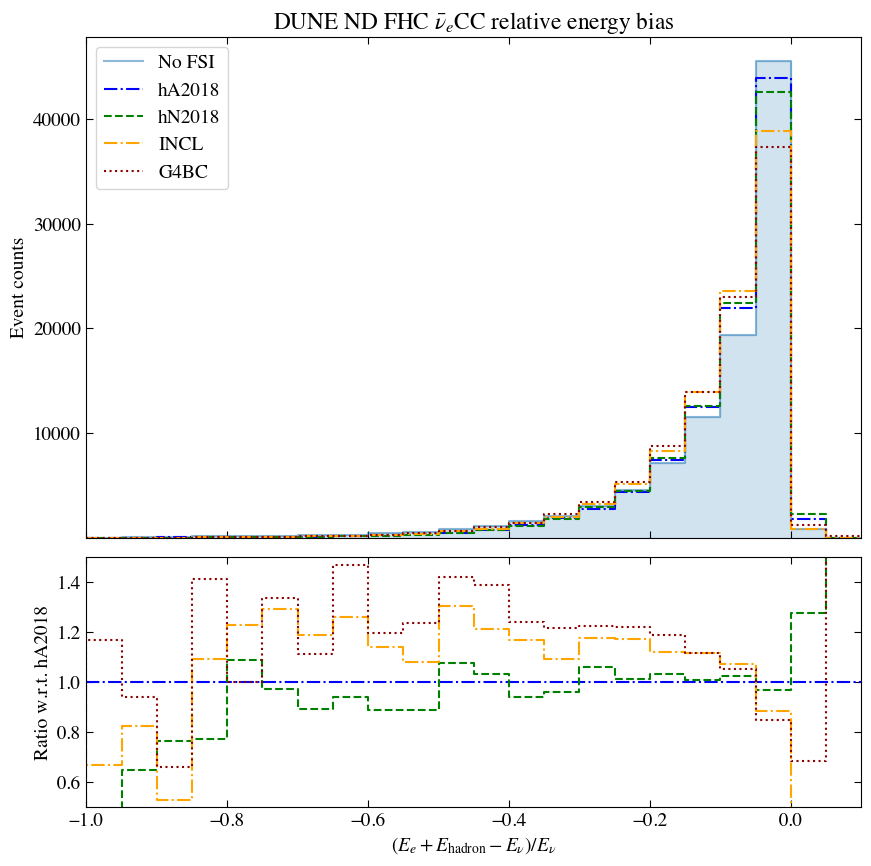

#events: 86158 88824 88836 88409 87003


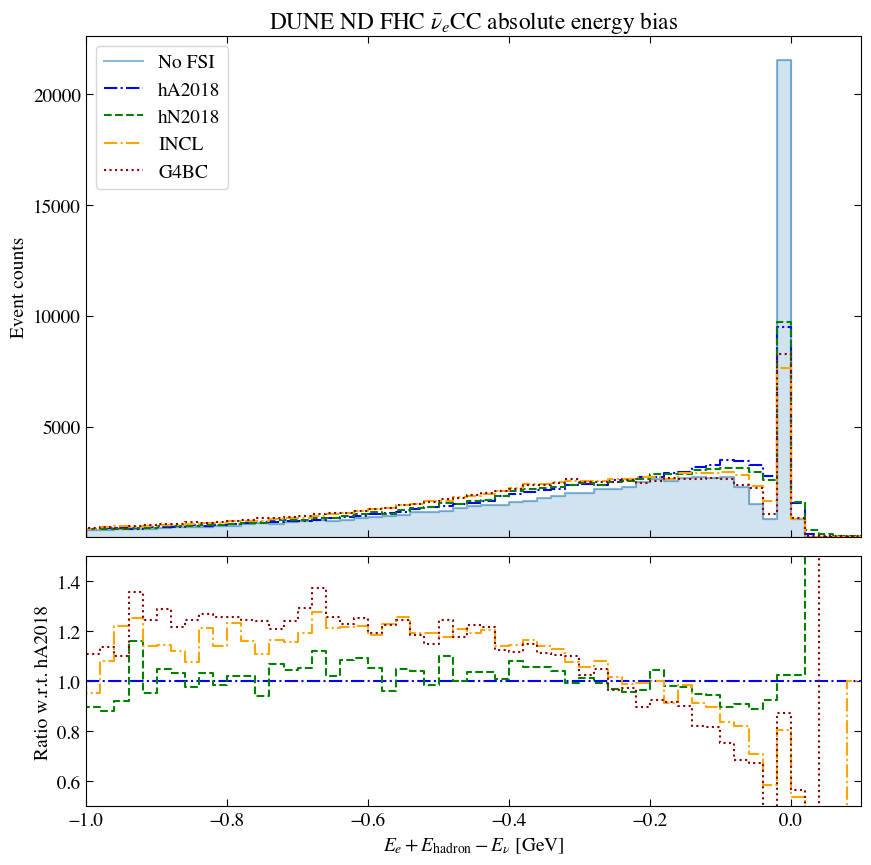

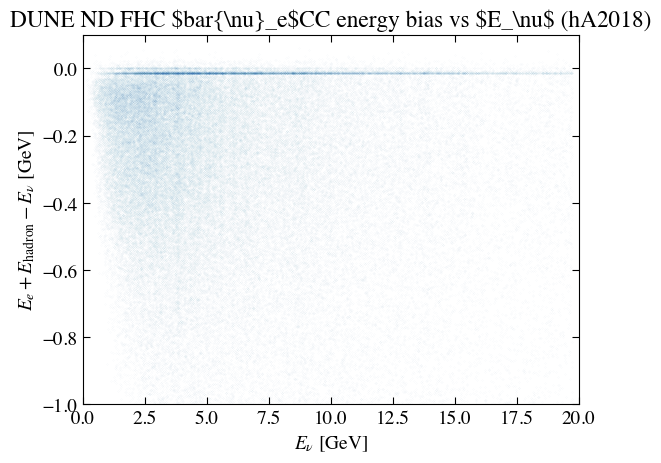

In [5]:
### relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_nueb_hA18/vars_nueb_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_nueb_hA18/vars_nueb_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_nueb_hN18/vars_nueb_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_nueb_INCL/vars_nueb_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_nueb_G4BC/vars_nueb_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\bar{\nu}_e$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_e+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/relaEvbias_Ehad_FSI_nueb.png")
plt.show()


### absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_nueb_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_nueb_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_nueb_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_nueb_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_nueb_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\bar{\nu}_e$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_e+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/absoEvbias_Ehad_FSI_nueb.png")
plt.show()


### energy bias vs neutrino energy
plt.scatter(vars_nueb_hA18["Ev"], Ebiasf_nueb_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_e+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND FHC $bar{\nu}_e\$CC energy bias vs $E_\nu$ (hA2018)")
#plt.savefig("FSIplots/2DEvbias_Ehad_hA18_nueb.png")
plt.show()


Check if all having the same #events: 9.999999999999998 10.0 9.999999999999998 10.000000000000002 10.0


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/61292219.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300 = FDosc_Flux_RHCnuebar_1300*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/61292219.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300 = FDosc_Flux_RHCnuebar_1300*1e7/ND_Flux_RHCnuebar


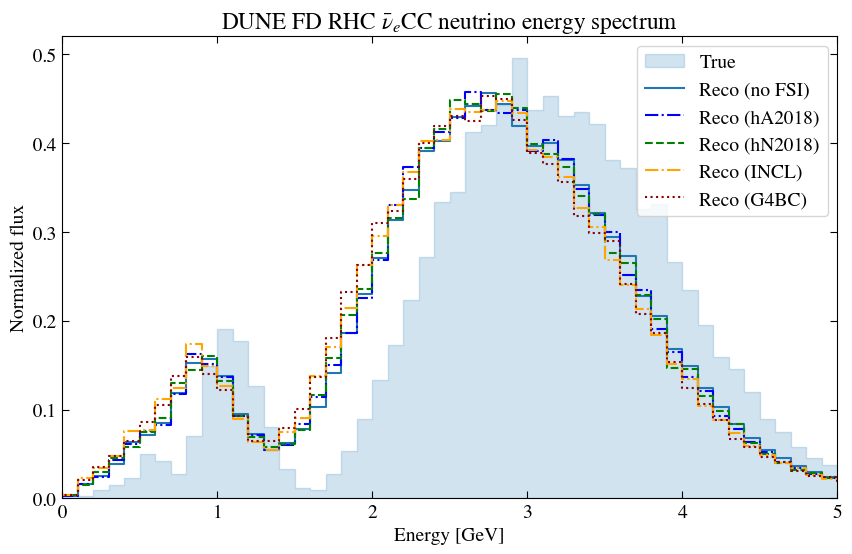

In [6]:
### oscillation plot
fluxND2FD_nueb_1300 = FDosc_Flux_RHCnuebar_1300*1e7/ND_Flux_RHCnuebar
ND2FD_nueb_wei_hA18 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300)
ND2FD_nueb_wei_hN18 = np.interp(vars_nueb_hN18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300)
ND2FD_nueb_wei_INCL = np.interp(vars_nueb_INCL["Ev"], FDosc_Ev, fluxND2FD_nueb_1300)
ND2FD_nueb_wei_G4BC = np.interp(vars_nueb_G4BC["Ev"], FDosc_Ev, fluxND2FD_nueb_1300)
#plt.hist(vars_nueb_hA18["Ev"], bins=100, alpha=0.3)
#plt.hist(vars_nueb_hA18["Ev"], bins=100, alpha=0.3, weights=ND2FD_nue_wei_hA18)
#plt.show()

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_nueb_hA18["Ev"], bins=xx, weights=ND2FD_nueb_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasi_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_nueb_hN18["Ev"]+Ebiasf_nueb_hN18, bins=xx, weights=ND2FD_nueb_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_nueb_INCL["Ev"]+Ebiasf_nueb_INCL, bins=xx, weights=ND2FD_nueb_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_nueb_G4BC["Ev"]+Ebiasf_nueb_G4BC, bins=xx, weights=ND2FD_nueb_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.2, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD RHC $\bar{\nu}_e$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nueb.png")
plt.show()

/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3709544784.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3709544784.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3709544784.py:3: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300_2 = FDosc_Flux_RHCnuebar_1300_2*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3709544784.py:3: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300_2 = FDosc_Flux_RHCnuebar_1300_2*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3709544784.py:4: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300_3

Check if all having the same #events: 268914.82094217814 10.0 268004.42585625546 268306.62613396 269498.1674458152


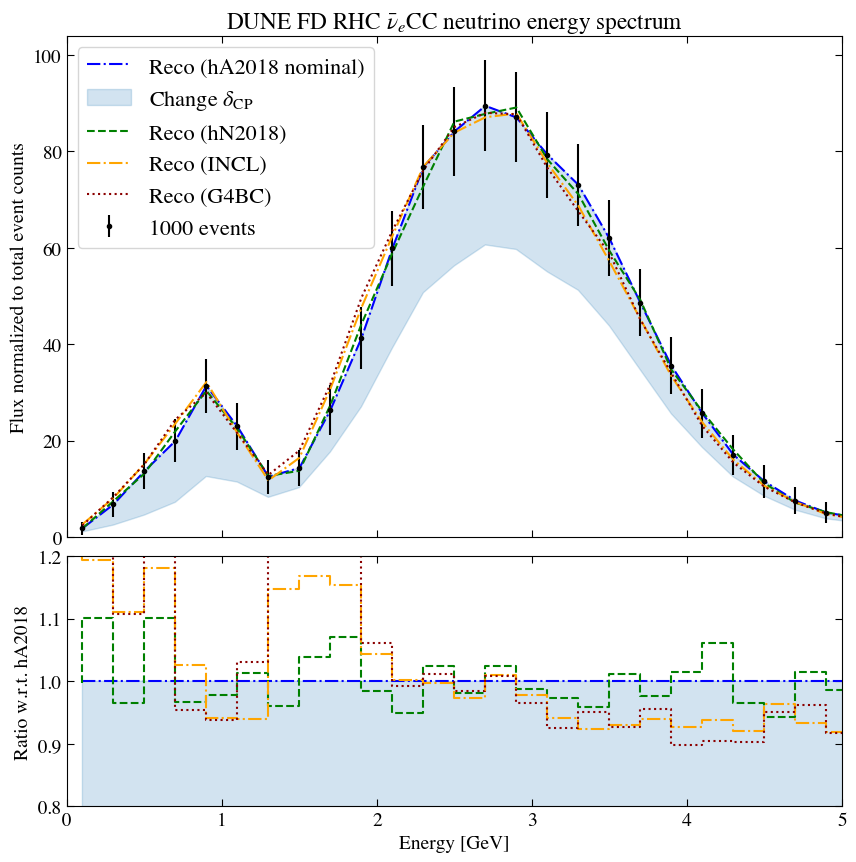

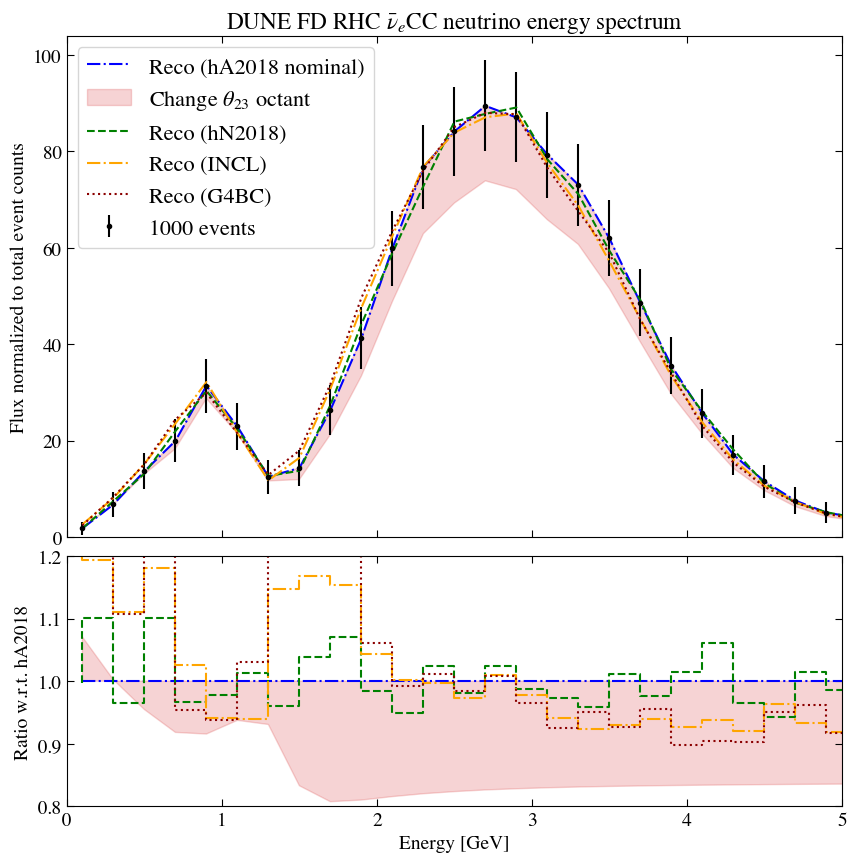

In [7]:
### oscillation sensitivity
fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
fluxND2FD_nueb_1300_2 = FDosc_Flux_RHCnuebar_1300_2*1e7/ND_Flux_RHCnuebar
fluxND2FD_nueb_1300_3 = FDosc_Flux_RHCnuebar_1300_3*1e7/ND_Flux_RHCnuebar

ND2FD_nueb_wei_1300 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300)
ND2FD_nueb_wei_1300_1 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1)
ND2FD_nueb_wei_1300_2 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_2)
ND2FD_nueb_wei_1300_3 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_3)

xx = np.arange(0, 20+0.2, 0.2)
yyi, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasi_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_hA18, density=False)
yyf_hN18, _ = np.histogram(vars_nueb_hN18["Ev"]+Ebiasf_nueb_hN18, bins=xx, weights=ND2FD_nueb_wei_hN18, density=False);
yyf_INCL, _ = np.histogram(vars_nueb_INCL["Ev"]+Ebiasf_nueb_INCL, bins=xx, weights=ND2FD_nueb_wei_INCL, density=False);
yyf_G4BC, _ = np.histogram(vars_nueb_G4BC["Ev"]+Ebiasf_nueb_G4BC, bins=xx, weights=ND2FD_nueb_wei_G4BC, density=False);
yyf_1300, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300, density=False); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_1300_1, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_1, density=False);
yyf_1300_2, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_2, density=False);
yyf_1300_3, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_3, density=False);
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = 1000 # estimated total event counts
scale = Nv/np.sum(yyf_1300)
xx = (xx[1:]+xx[:-1])/2

### δ_{CP}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"Change $\delta_{\rm CP}$", alpha=0.2, color='tab:blue')
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD RHC $\bar{\nu}_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.3*scale, 0.6*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
ax[1].fill_between(xx, safe_divide(yyf_1300_1, yyf_1300), safe_divide(yyf_1300, yyf_1300), alpha=0.2, color='tab:blue')
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nueb_dCP.png")
plt.show()

### octant of θ_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300, scale*yyf_1300_2, label=r"Change $\theta_{23}$ octant", alpha=0.2, color='tab:red')
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD RHC $\bar{\nu}_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
#ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.03*scale, 0.1*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
ax[1].fill_between(xx, safe_divide(yyf_1300_2, yyf_1300), safe_divide(yyf_1300, yyf_1300), alpha=0.2, color='tab:red')
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nueb_t23.png")
plt.show()


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300p = FDosc_Flux_RHCnuebar_1300p*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:2: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300p = FDosc_Flux_RHCnuebar_1300p*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:3: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300m = FDosc_Flux_RHCnuebar_1300m*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:3: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300m = FDosc_Flux_RHCnuebar_1300m*1e7/ND_Flux_RHCnuebar


Check if all having the same #events: 268914.82094217814 10.0 268004.42585625546 268306.62613396 269498.1674458152


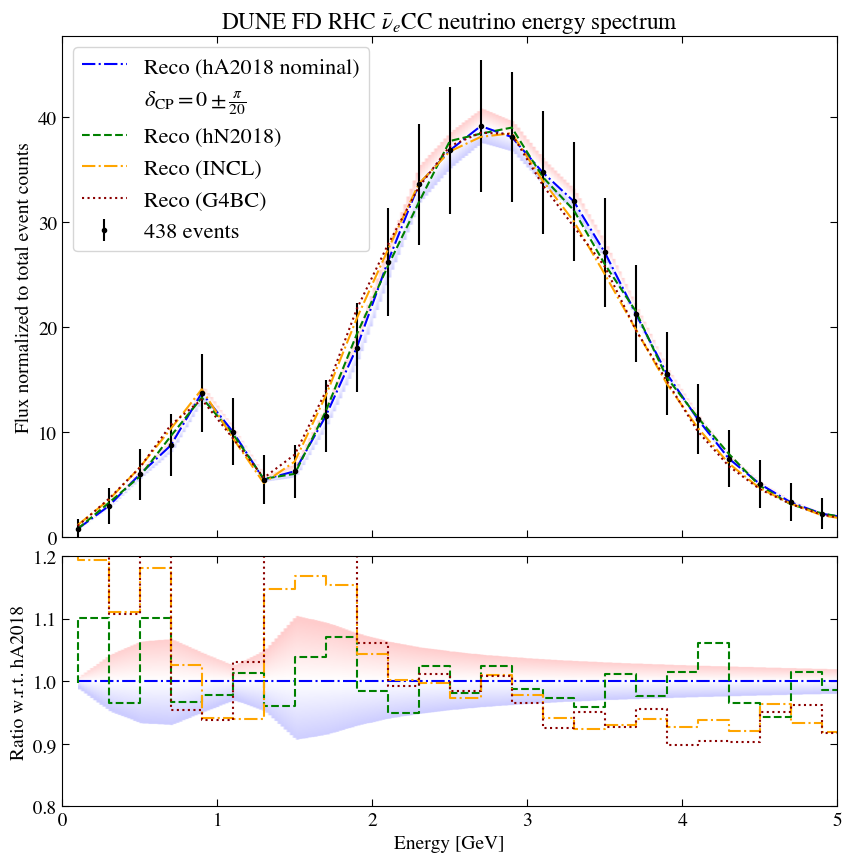

/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:65: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:65: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:66: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nueb_1300_1p = FDosc_Flux_RHCnuebar_1300_1p*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:66: RuntimeWarning: invalid value encountered in divide
  fluxND2FD_nueb_1300_1p = FDosc_Flux_RHCnuebar_1300_1p*1e7/ND_Flux_RHCnuebar
/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_84235/3618119828.py:67: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nu

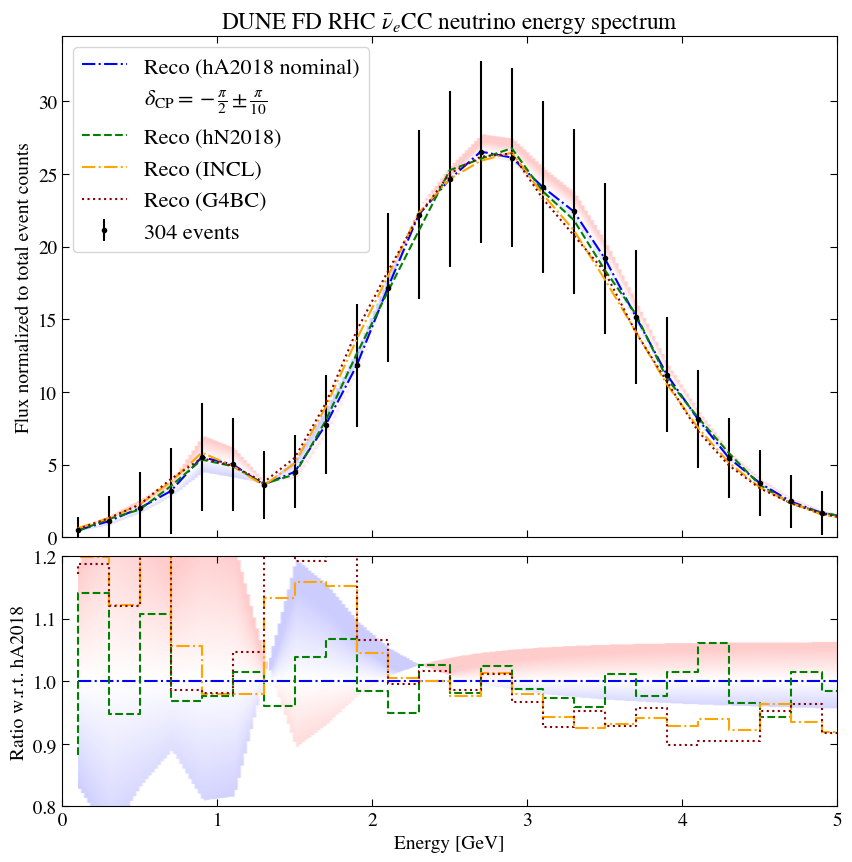

In [8]:
### oscillation sensitivity
fluxND2FD_nueb_1300p = FDosc_Flux_RHCnuebar_1300p*1e7/ND_Flux_RHCnuebar
fluxND2FD_nueb_1300m = FDosc_Flux_RHCnuebar_1300m*1e7/ND_Flux_RHCnuebar
ND2FD_nueb_wei_1300p = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300p)
ND2FD_nueb_wei_1300m = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300m)

xx = np.arange(0, 20+0.2, 0.2)
yyi, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasi_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_hA18, density=False)
yyf_hN18, _ = np.histogram(vars_nueb_hN18["Ev"]+Ebiasf_nueb_hN18, bins=xx, weights=ND2FD_nueb_wei_hN18, density=False);
yyf_INCL, _ = np.histogram(vars_nueb_INCL["Ev"]+Ebiasf_nueb_INCL, bins=xx, weights=ND2FD_nueb_wei_INCL, density=False);
yyf_G4BC, _ = np.histogram(vars_nueb_G4BC["Ev"]+Ebiasf_nueb_G4BC, bins=xx, weights=ND2FD_nueb_wei_G4BC, density=False);
yyf_1300, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300, density=False); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_1300p, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300p, density=False);
yyf_1300m, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300m, density=False);
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))
xx = (xx[1:]+xx[:-1])/2

### δ_{CP} = 0
Nv = int(236 *624/336) # estimated total event counts
scale = Nv/np.sum(yyf_1300)
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300p, scale*yyf_1300m, label=r"$\delta_{\rm CP}=0\pm\frac{\pi}{20}$", alpha=0, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_1300p, scale*yyf_1300m, alpha=0.2)

#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD RHC $\bar{\nu}_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.3*scale, 0.6*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_1300p, yyf_1300), safe_divide(yyf_1300m, yyf_1300), alpha=0.2, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_1300p, yyf_1300), safe_divide(yyf_1300m, yyf_1300), alpha=0.2)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_nueb_dCP0.png")
plt.show()


### δ_{CP} = -pi/2
Nv = int(164 *624/336) # estimated total event counts
fluxND2FD_nueb_1300_1 = FDosc_Flux_RHCnuebar_1300_1*1e7/ND_Flux_RHCnuebar
fluxND2FD_nueb_1300_1p = FDosc_Flux_RHCnuebar_1300_1p*1e7/ND_Flux_RHCnuebar
fluxND2FD_nueb_1300_1m = FDosc_Flux_RHCnuebar_1300_1m*1e7/ND_Flux_RHCnuebar
ND2FD_nueb_wei_1300_1 = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1)
ND2FD_nueb_wei_1300_1p = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1p)
ND2FD_nueb_wei_1300_1m = np.interp(vars_nueb_hA18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1m)
ND2FD_nueb_wei_hN18_1 = np.interp(vars_nueb_hN18["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1)
ND2FD_nueb_wei_INCL_1 = np.interp(vars_nueb_INCL["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1)
ND2FD_nueb_wei_G4BC_1 = np.interp(vars_nueb_G4BC["Ev"], FDosc_Ev, fluxND2FD_nueb_1300_1)
xx = np.arange(0, 20+0.2, 0.2)
yyf_hN18_1, _ = np.histogram(vars_nueb_hN18["Ev"]+Ebiasf_nueb_hN18, bins=xx, weights=ND2FD_nueb_wei_hN18_1);
yyf_INCL_1, _ = np.histogram(vars_nueb_INCL["Ev"]+Ebiasf_nueb_INCL, bins=xx, weights=ND2FD_nueb_wei_INCL_1);
yyf_G4BC_1, _ = np.histogram(vars_nueb_G4BC["Ev"]+Ebiasf_nueb_G4BC, bins=xx, weights=ND2FD_nueb_wei_G4BC_1);
yyf_1300_1, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_1);
yyf_1300_1p, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_1p);
yyf_1300_1m, _ = np.histogram(vars_nueb_hA18["Ev"]+Ebiasf_nueb_hA18, bins=xx, weights=ND2FD_nueb_wei_1300_1m);
xx = (xx[1:]+xx[:-1])/2

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300_1, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300_1, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300_1p, scale*yyf_1300_1m, label=r"$\delta_{\rm CP}=-\frac{\pi}{2}\pm\frac{\pi}{10}$", alpha=0, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300_1, scale*yyf_1300_1p, scale*yyf_1300_1m, alpha=0.2)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18_1, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL_1, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC_1, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD RHC $\bar{\nu}_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax[1].step(xx, safe_divide(yyf_1300_1, yyf_1300_1), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18_1, yyf_1300_1), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL_1, yyf_1300_1), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC_1, yyf_1300_1), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_1300_1p, yyf_1300_1), safe_divide(yyf_1300_1m, yyf_1300_1), alpha=0.2, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_1300_1p, yyf_1300_1), safe_divide(yyf_1300_1m, yyf_1300_1), alpha=0.2)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_nueb_dCP-90.png")
plt.show()
